In [16]:
import os
import math
import pandas as pd
import numpy as np
import pandas_ta as pdta
import matplotlib.pyplot as plt
import mplfinance as mpf


def data_range(df_dataset, from_date='', to_date='', window=100):
    dt_col = 'DATETIME' if 'DATETIME' in df_dataset else 'datetime'
    
    if from_date == '' and to_date == '':
        df_dataset = df_dataset.iloc[df_dataset.shape[0]-window:df_dataset.shape[0], :].copy()
    else:
        if from_date is not None and from_date != '' and to_date is not None and to_date != '':
            from_date = '{}000000'.format(from_date.replace('-', ''))
            to_date = '{}235500'.format(to_date.replace('-', ''))

            df_dataset = df_dataset.loc[(df_dataset[dt_col].astype(str) >= from_date) \
                                            & (df_dataset[dt_col].astype(str) <= to_date)]
            df_dataset = df_dataset.reset_index(drop=True)

    return df_dataset

def build_ohlc_df(df_master):
    df = pd.DataFrame(df_master, copy=True)
    df['DATETIME'] = df_master['DATETIME']
    df['Open'] = df_master['OPEN']
    df['High'] = df_master['HIGH']
    df['Low'] = df_master['LOW']
    df['Close'] = df_master['CLOSE']
    return df


def plot_df(data, col, title, x_label, y_label, plot_label, data_x=None, data_y=None
            , chart_width=20, chart_height=8
            , fontsize_axis=14, fontsize_title=20, fontsize_legend=1
            , legend_position='upper right'):
    plt.figure(figsize=(chart_width, chart_height))
    if data is not None:
        x = np.arange(data.shape[0])
        y = data[col]
    else:
        x = data_x
        y = data_y
    plt.plot(x, y, label=plot_label)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.title(title, fontsize=20)
    plt.legend(loc='upper right', fontsize=1)
    plt.show()

def plot_ohlc(data, type='candle', style='charles', title='Signals'
             , ylabel='Prices', figratio=(20, 8)
             , addplot=None,):
    if addplot is None:
        mpf.plot(data, type=type, style=style, title=title
                 , ylabel=ylabel, figratio=figratio
                 , **{'warn_too_much_data':data.shape[0] + 1}
                 ,)
    else:
        mpf.plot(data, type=type, style=style, title=title
                 , ylabel=ylabel, figratio=figratio, addplot=addplot
                 , **{'warn_too_much_data':data.shape[0] + 1}
                 ,)
        
def plot_ohlc_sig(data_ohlc, data_sig, markersize=100
                  , buy_pos=0.999, sell_pos=1.001
                  , c_width=30, c_height=8):

    sig_open_buy = np.where(data_sig['SIGNAL'] == 1, 1, 0)
    sig_open_sell = np.where(data_sig['SIGNAL'] == 11, 11, 0)

    sig_buy_arrow_pos = np.where(sig_open_buy > 0, 1, np.nan) * buy_pos * data_ohlc['Low']
    sig_sell_arrow_pos = np.where(sig_open_sell > 0, 1, np.nan) * sell_pos * data_ohlc['High']

    arrows = []
    if 1 in sig_open_buy:
        arrows.append(mpf.make_addplot(sig_buy_arrow_pos, scatter=True, markersize=markersize, marker=r'$\Uparrow$', color='green'))
    if 11 in sig_open_sell:
        arrows.append(mpf.make_addplot(sig_sell_arrow_pos, scatter=True, markersize=markersize, marker=r'$\Downarrow$', color='red'))
    
    plot_ohlc(data_ohlc
                , type='candle' # type='line'
                , style='charles'
                , title='Signals'
                , ylabel='Prices'
                , figratio=(c_width, c_height)
                , addplot=arrows
                ,)

In [18]:
class FELib:
    """
    Simple Feature Engineering Library
    """

    @staticmethod
    def iif(condition, resultTrue, resultFalse):
        return np.where(condition, resultTrue, resultFalse)

    @staticmethod
    def llv(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).min()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def hhv(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            # series = series.fillna(0)
            result = series.rolling(period, min_periods=1).max()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def ma(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).mean()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def stdev(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).std(skipna=True)
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

In [30]:
dataset_path = '../datasets/SET'

columns_master = ['DATETIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']

datetime_format = '%m/%d/%Y'

symbols = {} # key is symbol name, value is dataframe

with os.scandir(dataset_path) as entries:
    for entry in entries:
        if '.csv' in entry.name:
            data_symbol = pd.read_csv(f"{dataset_path}/{entry.name}")
            
            if 'Ticker' in data_symbol.columns:
                data_symbol.drop(['Ticker'], axis=1, inplace=True)
            
            if data_symbol.columns[-1].upper() != 'VOLUME':
                columns_master.remove('VOLUME')
                
            data_symbol.columns = columns_master
            data_symbol['DATETIME'] = pd.to_datetime(data_symbol['DATETIME'])
            symbols[entry.name.replace('.csv', '')] = data_symbol
            
print(f"total symbols is {len(symbols)}")
print(f"columns are {symbols[list(symbols.keys())[0]].columns}")
print(f"loaded symbols: {symbols.keys()}")

symbols[list(symbols.keys())[0]].head()

total symbols is 101
columns are Index(['DATETIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'], dtype='object')
loaded symbols: dict_keys(['GUNKUL', 'BANPU', 'SCB', 'SCC', 'TKN', 'COM-7', 'BBL', 'BCH', 'PSL', 'HMPRO', 'LH', 'ERW', 'GFPT', 'CPN', 'RATCH', 'CPALL', 'TCAP', 'VGI', 'PSH', 'CKP', 'ORI', 'THG', 'BTS', 'PRM', 'THAI', 'AAV', 'ADVANC', 'BGC', 'SPRC', 'WHA', 'DELTA', 'TOP', 'BJC', 'KCE', 'SAWAD', 'PTTEP', 'BDMS', 'EA', 'GULF', 'STPI', 'AMATA', 'BEM', 'TOA', 'COM', 'GPSC', 'PTT', 'BEC', 'KTC', 'BCPG', 'CBG', 'SUPER', 'AOT', 'KTB', 'DTAC', 'PTTGC', 'HANA', 'MBK', 'RS', 'QH', 'AEONTS', 'MTC', 'IRPC', 'SGP', 'AWC', 'TMB', 'TTW', 'IVL', 'BPP', 'STEC', 'CENTEL', 'THANI', 'MINT', 'TISCO', 'KBANK', 'PTG', 'EPG', 'PLANB', 'BH', 'CHG', 'JMT', 'GLOBAL', 'STA', 'AP', 'TASCO', 'BGRIM', 'TRUE', 'INTUCH', 'MAJOR', 'SPALI', 'OSP', 'MEGA', 'TU', 'CK', 'CPF', 'TPIPP', 'BCP', 'EGCO', 'KKP', 'TQM', 'JAS', 'ESSO'])


DATETIME  OPEN  HIGH   LOW  CLOSE      VOLUME
0 2010-10-19  0.53  0.56  0.46   0.46  2129458560
1 2010-10-20  0.46  0.48  0.45   0.45   666349824
2 2010-10-21  0.46  0.46  0.40   0.40   733716864
3 2010-10-22  0.41  0.42  0.39   0.41   520451744
4 2010-10-26  0.41  0.41  0.39   0.39   177441168

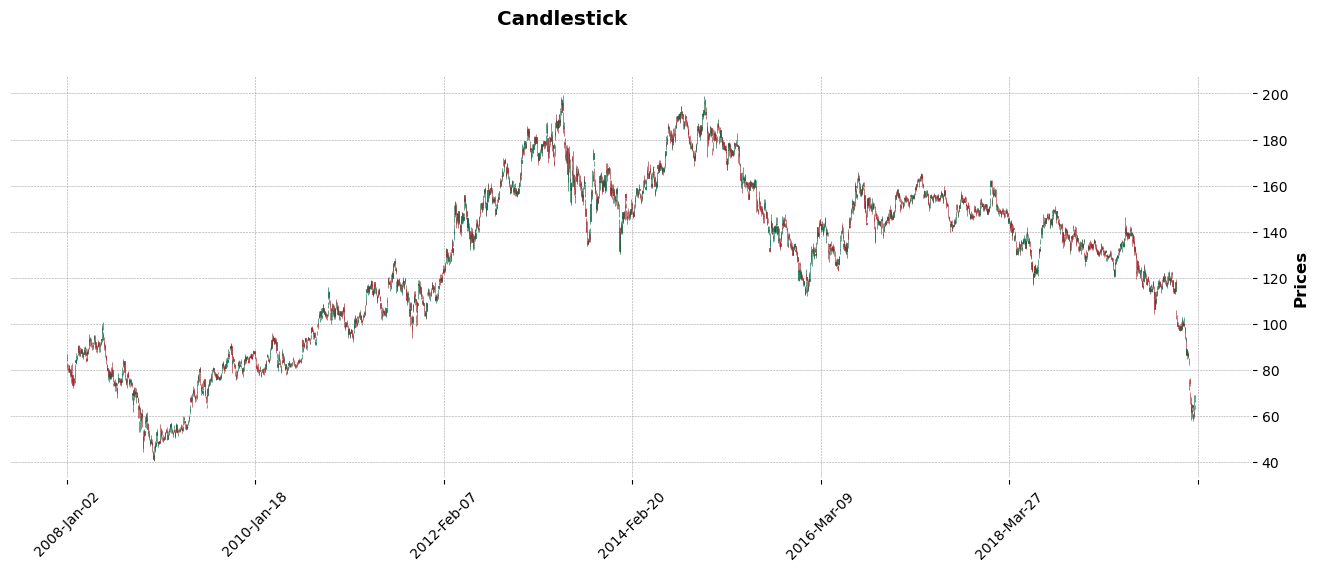

In [33]:
# Plot candlestick chart

# ระบุ date_start กับ date_end หรือระบุ window_chart อย่างใดอย่างหนึ่ง
date_start = '2007-01-01' # example: 20200101 format is YYYYmmdd or 2020-01-01 format is YYYY-mm-dd
date_end = '2022-12-31' # example: 20200131 format is YYYYmmdd or 2020-01-31 format is YYYY-mm-dd
window_chart = 2000 # candles

chart_width = 30 # ระบุความกว้า่ง
chart_height = 10 # ระบุความสูง

sample_symbol = 'SCB'

df_symbol = symbols[sample_symbol]

df_ohlc = pd.DataFrame()

df_ohlc['DATETIME'] = df_symbol['DATETIME']
df_ohlc['Open'] = df_symbol['OPEN']
df_ohlc['High'] = df_symbol['HIGH']
df_ohlc['Low'] = df_symbol['LOW']
df_ohlc['Close'] = df_symbol['CLOSE']

# Get sub data
df_ohlc = data_range(df_ohlc, from_date=date_start, to_date=date_end, window=window_chart)

df_ohlc['DATETIME'] = pd.to_datetime(df_ohlc['DATETIME'], format=datetime_format)
df_ohlc.set_index('DATETIME', inplace=True)

plot_ohlc(df_ohlc
            , type='candle' # type='line'
            , style='charles'
            , title='Candlestick'
            , ylabel='Prices'
            , figratio=(chart_width, chart_height),)

In [40]:
import multiprocessing

def add_indi(symbol_name, dataset):
    
    # SMA
    dataset['MA1'] = pdta.sma(dataset['CLOSE'], 10)

    # WMA
    dataset['MA2'] = pdta.wma(dataset['CLOSE'], 50)

    # EMA
    dataset['MA3'] = pdta.ema(dataset['CLOSE'], 200)

    # RSI
    dataset['RSI_S'] = pdta.rsi(dataset['CLOSE'], 10)
    dataset['RSI_M'] = pdta.ema( pdta.rsi(dataset['CLOSE'], 28), 10 )

    # MACD
    df_macd_s = pdta.macd(dataset['CLOSE'], 12, 26, 9)
    dataset['MACD_S'] = df_macd_s.iloc[:, 0]
    dataset['MACD_HIST_S'] = df_macd_s.iloc[:, 1]
    dataset['MACD_SIGNAL_S'] = df_macd_s.iloc[:, 2]

    # ATR
    dataset['ATR'] = pdta.atr(dataset['HIGH']
                              , dataset['LOW']
                              , dataset['CLOSE']
                              , 20)

    # NATR (Normalized Average True Range)
    dataset['NATR'] = pdta.natr(dataset['HIGH']
                              , dataset['LOW']
                              , dataset['CLOSE']
                              , 20)
    dataset['NATR'] = dataset['NATR'] * 100

    # Slow Stochastics
    df_slow_s = pdta.stoch(dataset['HIGH']
                           , dataset['LOW']
                           , dataset['CLOSE']
                           , 9, 3, 3, 'wma')
    dataset['STOCHK_S'] = df_slow_s.iloc[:, 0]
    dataset['STOCHD_S'] = df_slow_s.iloc[:, 1]

    # Slow Stochastics
    df_slow_m = pdta.stoch(dataset['HIGH']
                           , dataset['LOW']
                           , dataset['CLOSE']
                           , 36, 12, 12, 'wma')
    dataset['STOCHK_M'] = df_slow_m.iloc[:, 0]
    dataset['STOCHD_M'] = df_slow_m.iloc[:, 1]

    dataset.fillna(0.0, inplace=True) # fill ค่า NaN ด้วยค่า 0.0
    
    print(f"calculate and add indicators to {symbol_name} success")
    print("==========================================================")

    

for symbol_name in symbols.keys():
    %time add_indi(symbol_name, symbols[symbol_name])

    
symbols[sample_symbol]

calculate and add indicators to GUNKUL success
CPU times: user 14.6 ms, sys: 3.93 ms, total: 18.6 ms
Wall time: 24.5 ms
calculate and add indicators to BANPU success
CPU times: user 17.5 ms, sys: 1.07 ms, total: 18.5 ms
Wall time: 18.7 ms
calculate and add indicators to SCB success
CPU times: user 19.3 ms, sys: 1.24 ms, total: 20.5 ms
Wall time: 20.6 ms
calculate and add indicators to SCC success
CPU times: user 18.8 ms, sys: 628 µs, total: 19.5 ms
Wall time: 19.5 ms
calculate and add indicators to TKN success
CPU times: user 6.88 ms, sys: 71 µs, total: 6.95 ms
Wall time: 6.95 ms
calculate and add indicators to COM-7 success
CPU times: user 6.62 ms, sys: 65 µs, total: 6.68 ms
Wall time: 6.69 ms
calculate and add indicators to BBL success
CPU times: user 17.5 ms, sys: 1.16 ms, total: 18.7 ms
Wall time: 18.7 ms
calculate and add indicators to BCH success
CPU times: user 10.2 ms, sys: 130 µs, total: 10.3 ms
Wall time: 10.3 ms
calculate and add indicators to PSL success
CPU times: user 13.

calculate and add indicators to HANA success
CPU times: user 14.6 ms, sys: 469 µs, total: 15.1 ms
Wall time: 15 ms
calculate and add indicators to MBK success
CPU times: user 13.5 ms, sys: 295 µs, total: 13.8 ms
Wall time: 13.7 ms
calculate and add indicators to RS success
CPU times: user 11.2 ms, sys: 612 µs, total: 11.8 ms
Wall time: 11.8 ms
calculate and add indicators to QH success
CPU times: user 15.2 ms, sys: 379 µs, total: 15.6 ms
Wall time: 15.6 ms
calculate and add indicators to AEONTS success
CPU times: user 10.9 ms, sys: 426 µs, total: 11.3 ms
Wall time: 11.3 ms
calculate and add indicators to MTC success
CPU times: user 6.73 ms, sys: 67 µs, total: 6.8 ms
Wall time: 6.8 ms
calculate and add indicators to IRPC success
CPU times: user 13.4 ms, sys: 567 µs, total: 14 ms
Wall time: 14 ms
calculate and add indicators to SGP success
CPU times: user 9.03 ms, sys: 225 µs, total: 9.26 ms
Wall time: 9.28 ms
calculate and add indicators to AWC success
CPU times: user 5.02 ms, sys: 57 µ

DATETIME   OPEN   HIGH    LOW  CLOSE    VOLUME     MA1        MA2  \
0    1984-01-04  16.32  16.32  16.32  16.32     27613   0.000   0.000000   
1    1984-01-05  16.25  16.25  16.25  16.25     73200   0.000   0.000000   
2    1984-01-06  16.25  16.32  16.25  16.32     11720   0.000   0.000000   
3    1984-01-09  16.32  16.32  16.32  16.32       675   0.000   0.000000   
4    1984-01-10  16.32  16.32  16.25  16.32      5500   0.000   0.000000   
...         ...    ...    ...    ...    ...       ...     ...        ...   
8808 2020-03-25  61.00  61.75  59.25  60.75  16970700  62.300  80.789216   
8809 2020-03-26  60.75  64.75  60.00  64.00  19923800  62.075  79.805294   
8810 2020-03-27  65.75  69.25  65.00  66.25  33653000  62.050  78.948824   
8811 2020-03-30  64.00  65.00  63.25  64.50  14345600  62.275  78.064314   
8812 2020-03-31  67.25  69.25  66.00  69.25  21110900  63.000  77.407255   

             MA3      RSI_S      RSI_M    MACD_S  MACD_HIST_S  MACD_SIGNAL_S  \
0       0.000000   0.000000   0.000000  0.000000     0.000000       0.000000   
1       0.000000   0.000000   0.000000  0.000000     0.000000       0.000000   
2       0.000000   0.000000   0.000000  0.000000     0.000000       0.000000   
3       0.000000   0.000000   0.000000  0.000000     0.000000       0.000000   
4       0.000000   0.000000   0.000000  0.000000     0.000000       0.000000   
...          ...        ...        ...       ...          ...            ...   
8808  109.350219  26.945124  25.197395 -9.360855    -0.383544      -8.977311   
8809  108.898973  36.660135  26.212871 -8.788435     0.151101      -8.939536   
8810  108.474605  42.538145  27.511051 -8.060318     0.703375      -8.763692   
8811  108.037047  39.379934  28.396847 -7.537601     0.980873      -8.518474   
8812  107.651106  50.470207  30.051799 -6.663249     1.484180      -8.147429   

           ATR        NATR   STOCHK_S   STOCHD_S   STOCHK_M  STOCHD_M  
0     0.000000    0.000000   0.000000   0.000000   0.000000  0.000000  
1     0.000000    0.000000   0.000000   0.000000   0.000000  0.000000  
2     0.000000    0.000000   0.000000   0.000000   0.000000  0.000000  
3     0.000000    0.000000   0.000000   0.000000   0.000000  0.000000  
4     0.000000    0.000000   0.000000   0.000000   0.000000  0.000000  
...        ...         ...        ...        ...        ...       ...  
8808  3.807356  626.725289  16.319396  14.312851   7.006479  7.492726  
8809  3.854488  602.263801  48.986100  31.692394   7.880900  7.637450  
8810  3.924264  592.341722  66.944663  52.520931   9.455805  7.980576  
8811  3.878051  601.248172  66.236559  63.597517  10.286134  8.393495  
8812  3.921648  566.302986  81.481481  73.977038  12.589171  9.088697  

[8813 rows x 20 columns]

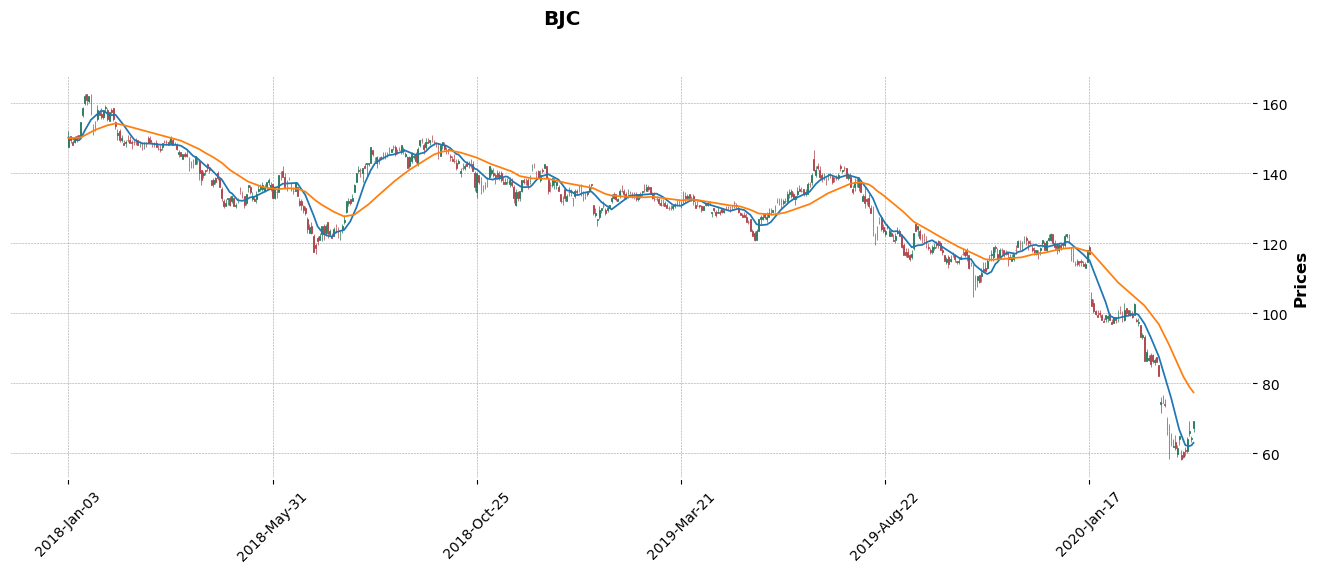

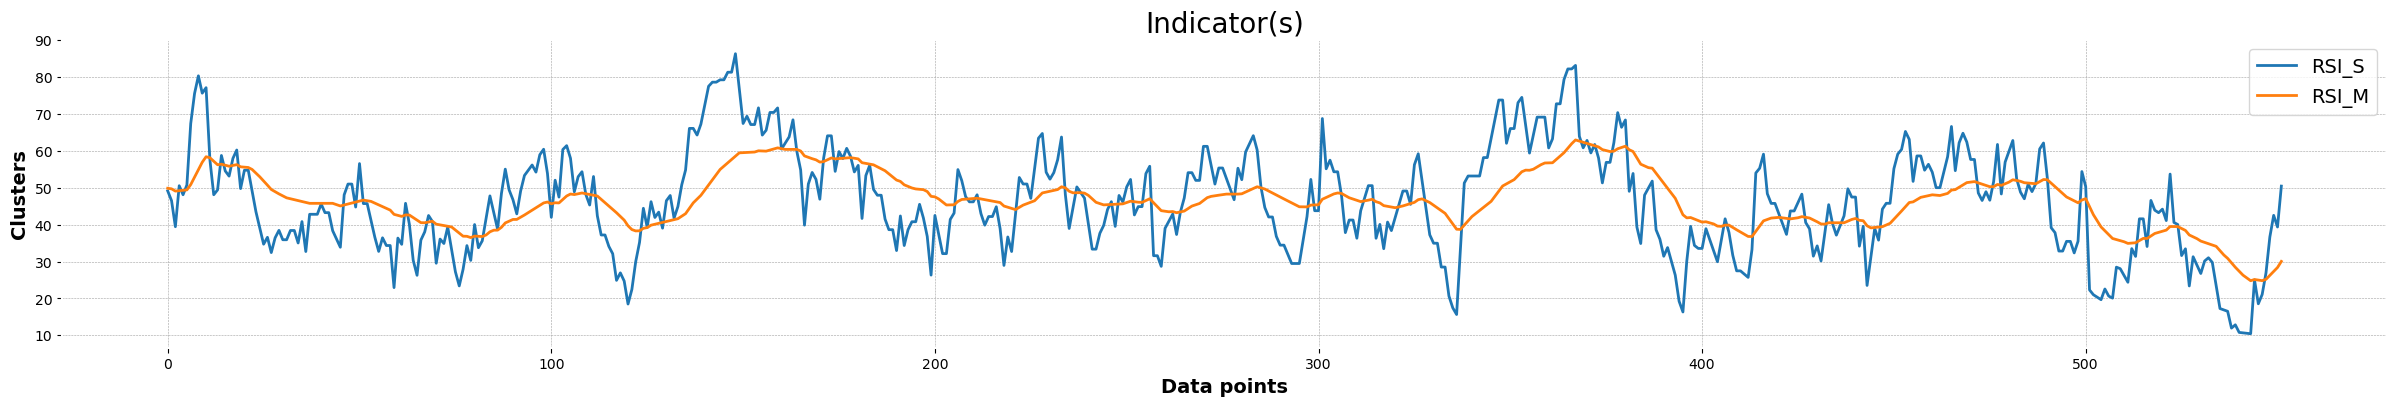

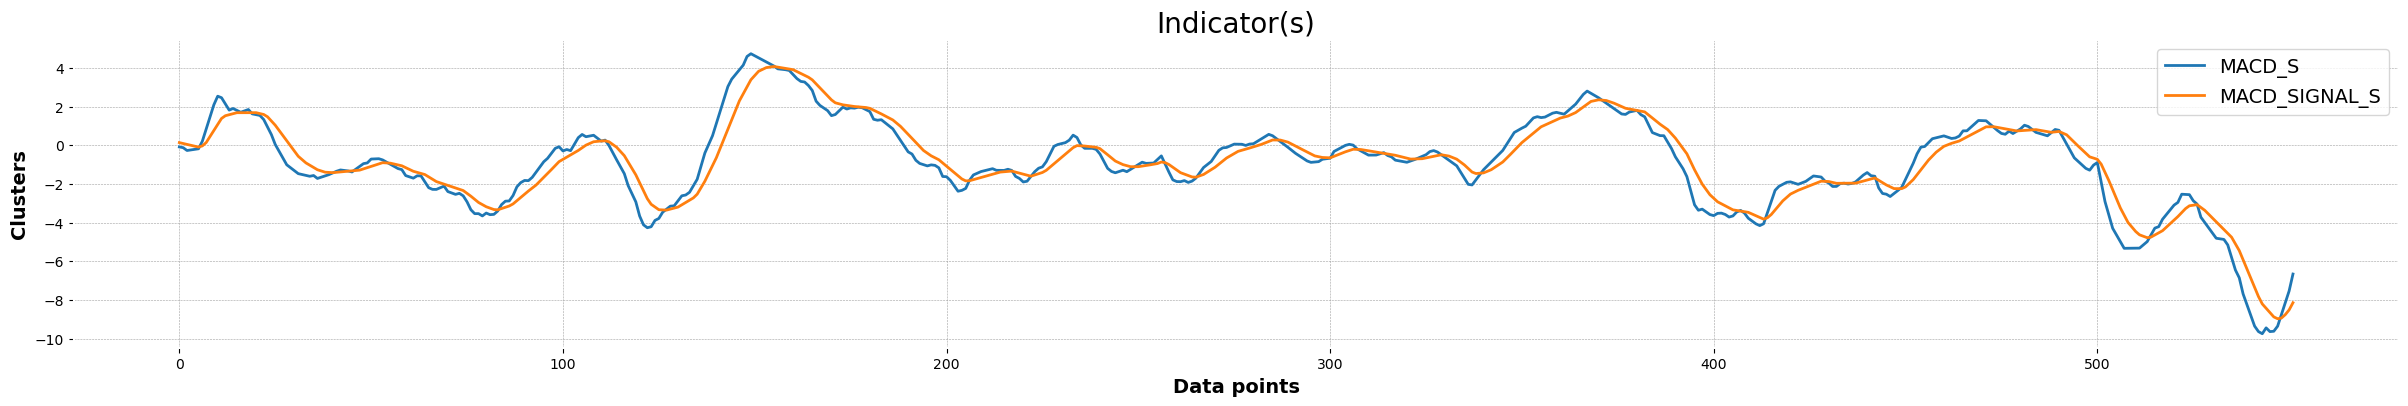

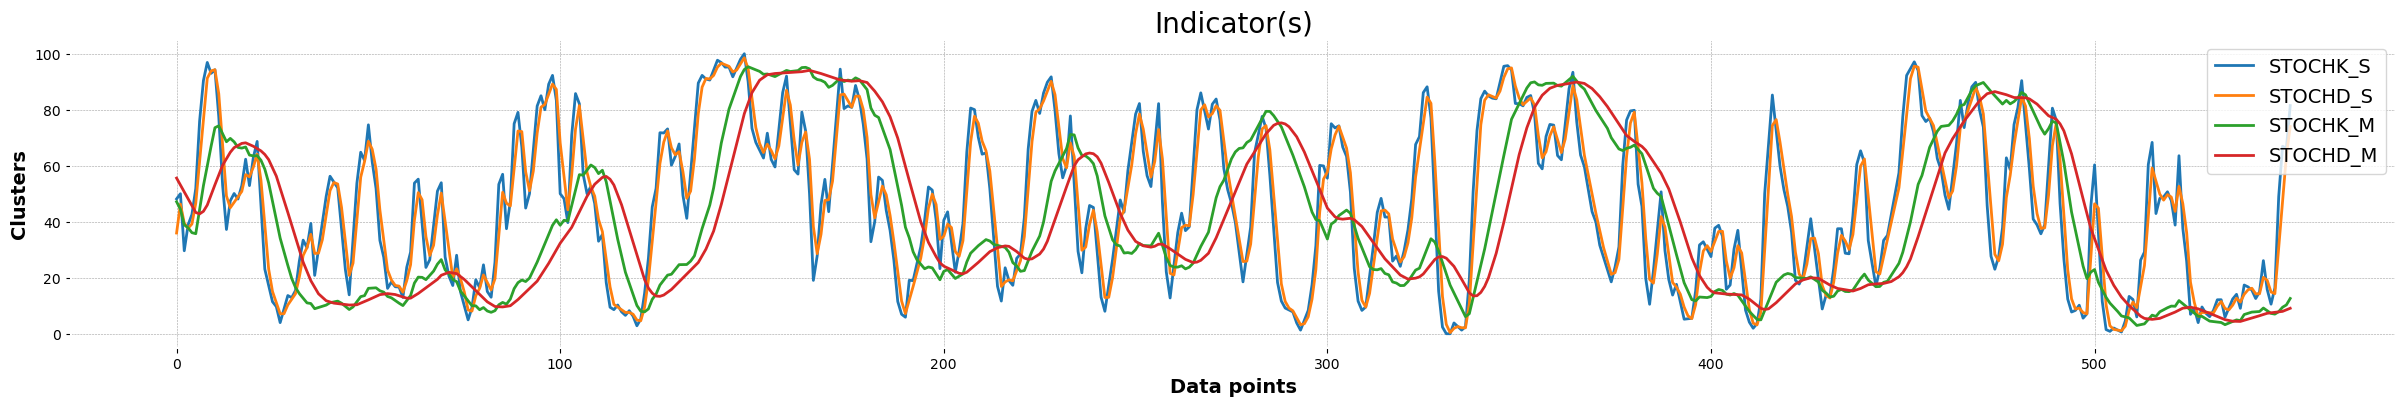

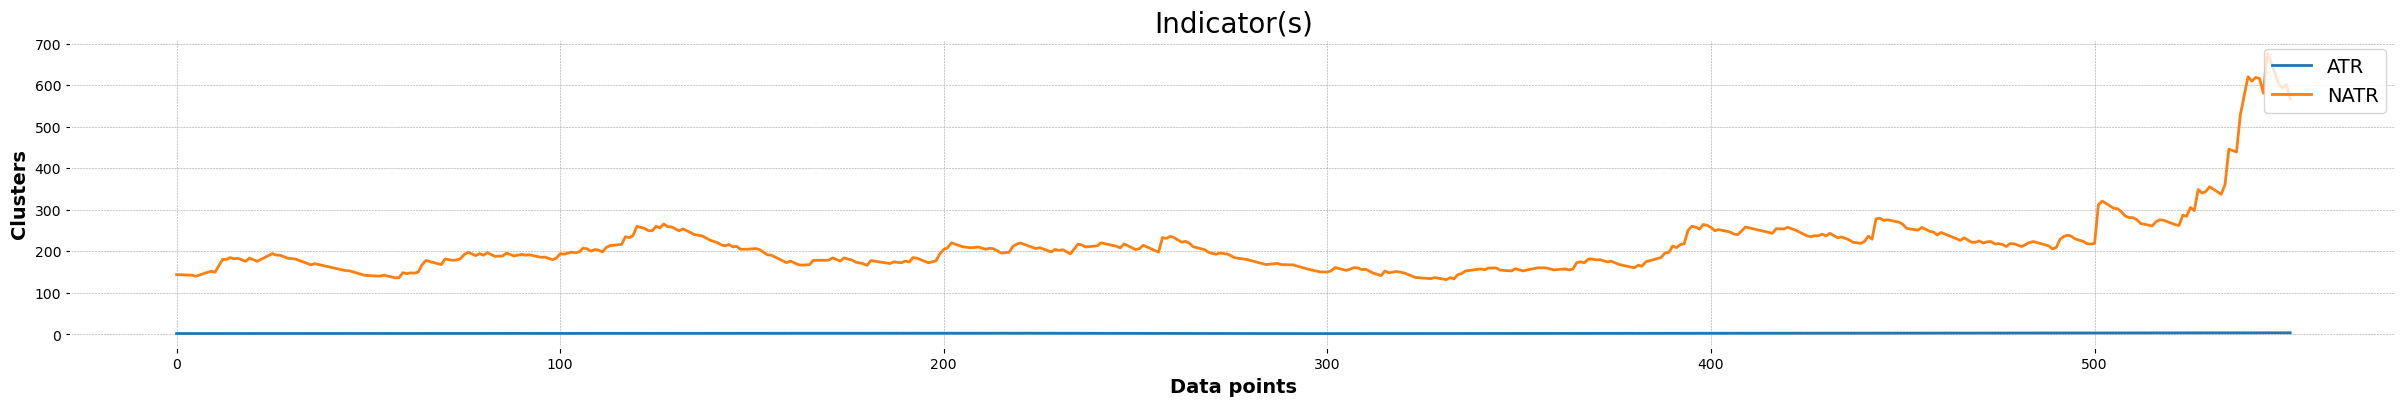

In [87]:
# ระบุ date_start กับ date_end หรือระบุ window_chart อย่างใดอย่างหนึ่ง
date_start = '2017-01-01' # example: 20200101 format is YYYYmmdd or 2020-01-01 format is YYYY-mm-dd
date_end = '2022-12-31' # example: 20200131 format is YYYYmmdd or 2020-01-31 format is YYYY-mm-dd
window_chart = 2000 # candles

chart_width = 30 # ระบุความกว้า่ง
chart_height = 10 # ระบุความสูง

# Get sub data
df = data_range(symbols[sample_symbol], from_date=date_start, to_date=date_end, window=window_chart)
new_total_rows = df.shape[0]
    

df_ohlc = pd.DataFrame()
df_ohlc['DATETIME'] = df['DATETIME']
df_ohlc['Open'] = df['OPEN']
df_ohlc['High'] = df['HIGH']
df_ohlc['Low'] = df['LOW']
df_ohlc['Close'] = df['CLOSE']

# Get sub data
df_ohlc = data_range(df_ohlc, from_date=date_start, to_date=date_end, window=window_chart)

df_ohlc['DATETIME'] = pd.to_datetime(df_ohlc['DATETIME'], format=datetime_format)
df_ohlc.set_index('DATETIME', inplace=True)
    
#===============================================================================================

# Plot candles chart

apdict_ma1 = mpf.make_addplot(df['MA1'])
apdict_ma2 = mpf.make_addplot(df['MA2'])
plot_ohlc(df_ohlc
                  , type='candle' # type='line'
                  , style='charles'
                  , title=scanned_symbol
                  , ylabel='Prices'
                  , figratio=(chart_width, chart_height)
                  , addplot=[apdict_ma1, apdict_ma2]
                  ,)

#===============================================================================================

def plot_indi(data, cols):    
    for i in range(0, len(cols)):
        x = np.arange(new_total_rows)
        y = data[cols[i]]
        plt.plot(x, y, label=cols[i])

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_S', 'RSI_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['MACD_S', 'MACD_SIGNAL_S'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['STOCHK_S', 'STOCHD_S', 'STOCHK_M', 'STOCHD_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['ATR', 'NATR'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [92]:
class BaseScanner:

    def eval_condition(self, symbol_name, dataset):
        """
        Sample code:
        
        result = False

        predict_result = np.where((dataset.MA1 > dataset.MA2)
                                 , 1, 0)
        if predict_result[-1] == 1:
            result = True

        return result
        """
        raise NotImplementedError

    def scan(self, list_symbol):
        scan_results = []

        for symbol_name in list_symbol.keys():
            result = self.eval_condition(symbol_name, list_symbol[symbol_name])

            scan_results.append({'SYMBOL': symbol_name, 'SCAN_RESULT': result})
            print(f"symbol: {symbol_name}, result: {result}")
            print("==========================================================")
            
        return scan_results
    
# =================================================================================
    
class SETEquityScanner(BaseScanner):

    def eval_condition(self, symbol_name, dataset):
        result = False

        predict_result = np.where((dataset.RSI_S > 45)
                                 , 1, 0)
        if predict_result[-1] == 1:
            result = True

        return result
    
# =================================================================================

set_equity_scanner = SETEquityScanner()
# start scanning
scanned_symbols = set_equity_scanner.scan(symbols)

# convert scanned results to dataframe
df_scan_result = pd.DataFrame(scanned_symbols)

df_scan_result

symbol: GUNKUL, result: True
symbol: BANPU, result: False
symbol: SCB, result: True
symbol: SCC, result: True
symbol: TKN, result: False
symbol: COM-7, result: True
symbol: BBL, result: True
symbol: BCH, result: False
symbol: PSL, result: False
symbol: HMPRO, result: True
symbol: LH, result: False
symbol: ERW, result: False
symbol: GFPT, result: False
symbol: CPN, result: True
symbol: RATCH, result: True
symbol: CPALL, result: False
symbol: TCAP, result: False
symbol: VGI, result: False
symbol: PSH, result: False
symbol: CKP, result: False
symbol: ORI, result: False
symbol: THG, result: False
symbol: BTS, result: False
symbol: PRM, result: True
symbol: THAI, result: False
symbol: AAV, result: False
symbol: ADVANC, result: True
symbol: BGC, result: True
symbol: SPRC, result: False
symbol: WHA, result: False
symbol: DELTA, result: False
symbol: TOP, result: False
symbol: BJC, result: True
symbol: KCE, result: False
symbol: SAWAD, result: False
symbol: PTTEP, result: False
symbol: BDMS, r

SYMBOL  SCAN_RESULT
0    GUNKUL         True
1     BANPU        False
2       SCB         True
3       SCC         True
4       TKN        False
..      ...          ...
96     EGCO         True
97      KKP        False
98      TQM         True
99      JAS         True
100    ESSO         True

[101 rows x 2 columns]

In [93]:
df_scan_result.loc[(df_scan_result.SCAN_RESULT == True)]

SYMBOL  SCAN_RESULT
0    GUNKUL         True
2       SCB         True
3       SCC         True
5     COM-7         True
6       BBL         True
9     HMPRO         True
13      CPN         True
14    RATCH         True
23      PRM         True
26   ADVANC         True
27      BGC         True
32      BJC         True
37       EA         True
38     GULF         True
41      BEM         True
42      TOA         True
44     GPSC         True
45      PTT         True
48     BCPG         True
49      CBG         True
50    SUPER         True
52      KTB         True
53     DTAC         True
54    PTTGC         True
55     HANA         True
61     IRPC         True
62      SGP         True
64      TMB         True
65      TTW         True
66      IVL         True
67      BPP         True
69   CENTEL         True
73    KBANK         True
75      EPG         True
81      STA         True
84    BGRIM         True
85     TRUE         True
86   INTUCH         True
88    SPALI         True
89      OSP         True
90     MEGA         True
91       TU         True
92       CK         True
93      CPF         True
96     EGCO         True
98      TQM         True
99      JAS         True
100    ESSO         True

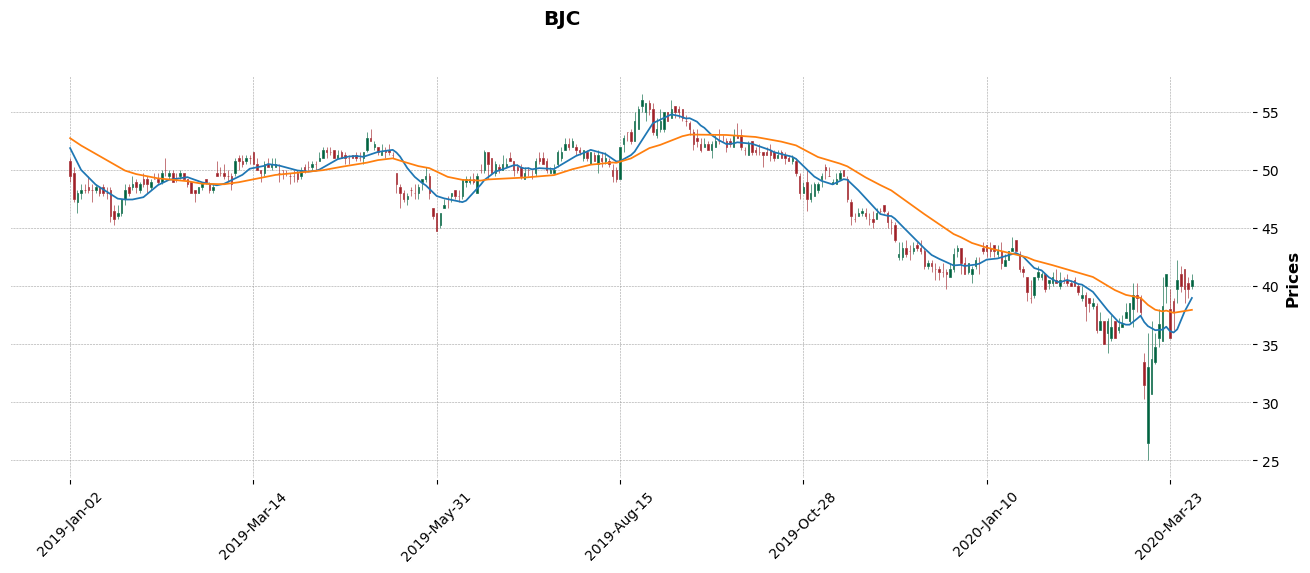

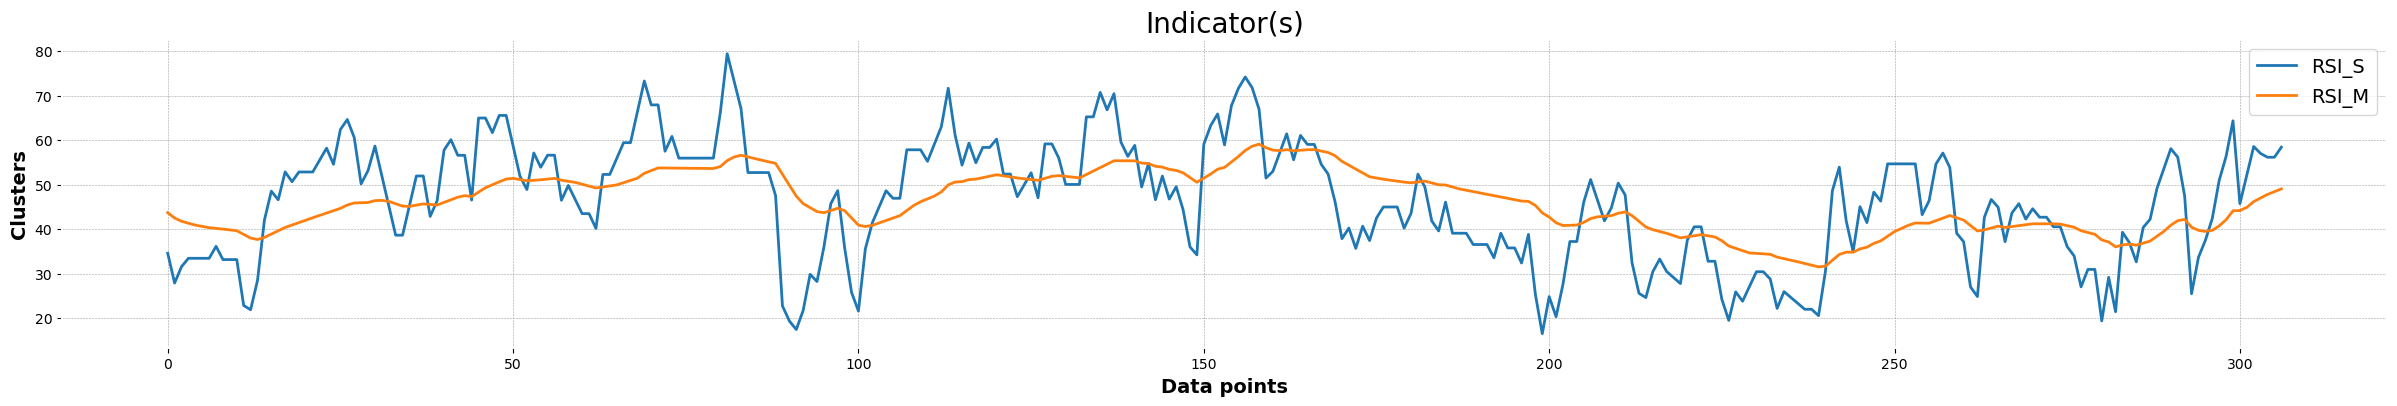

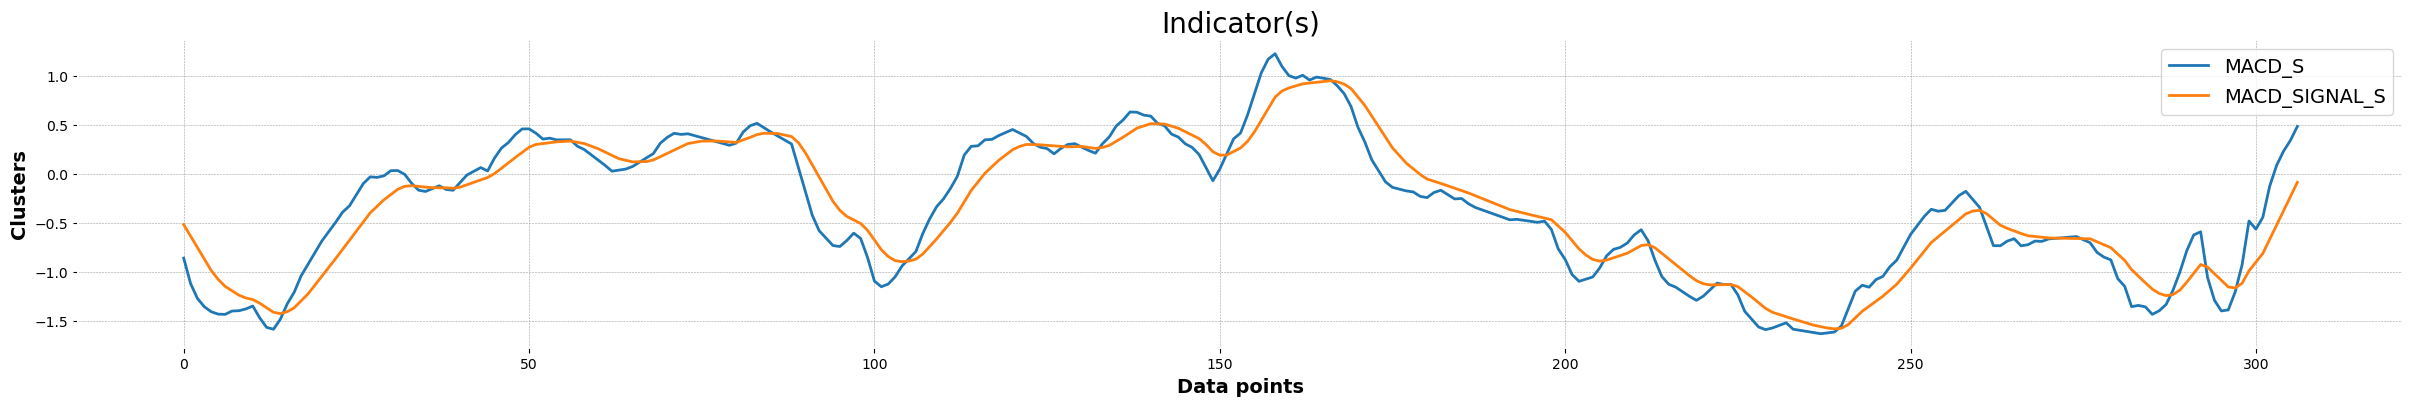

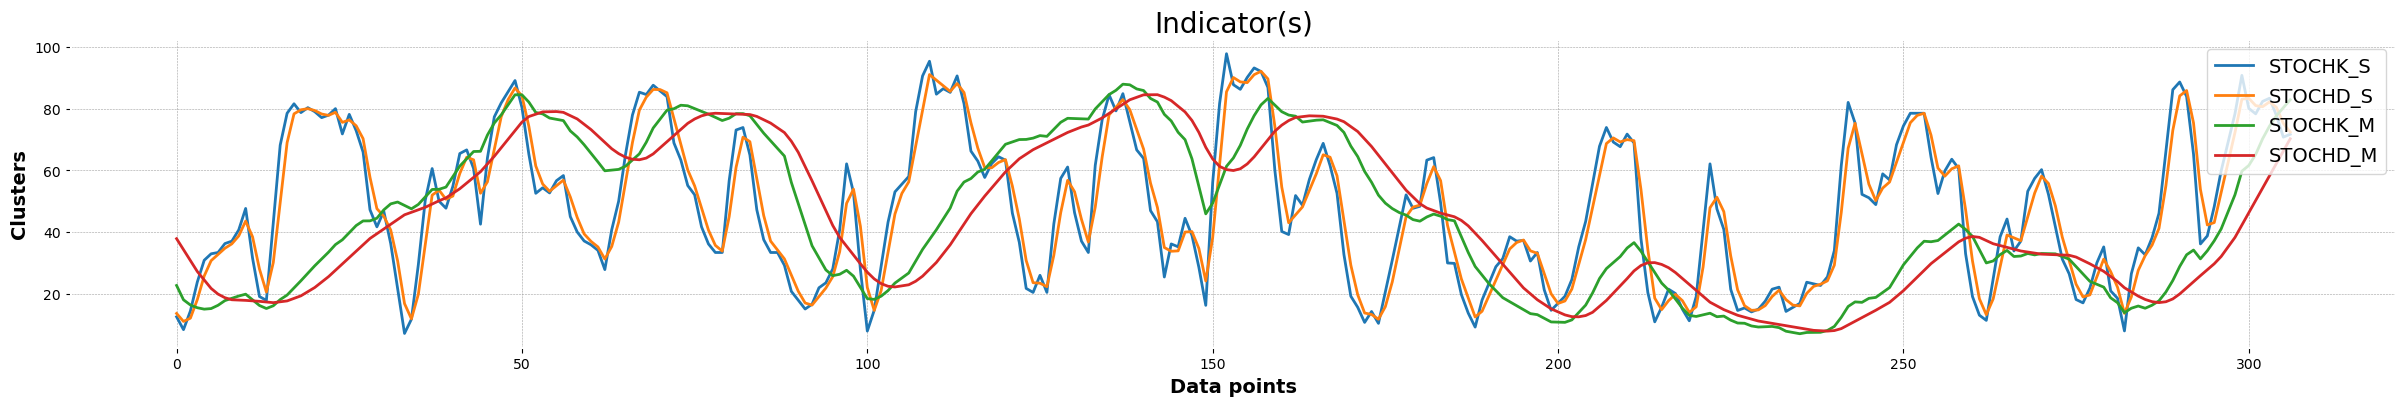

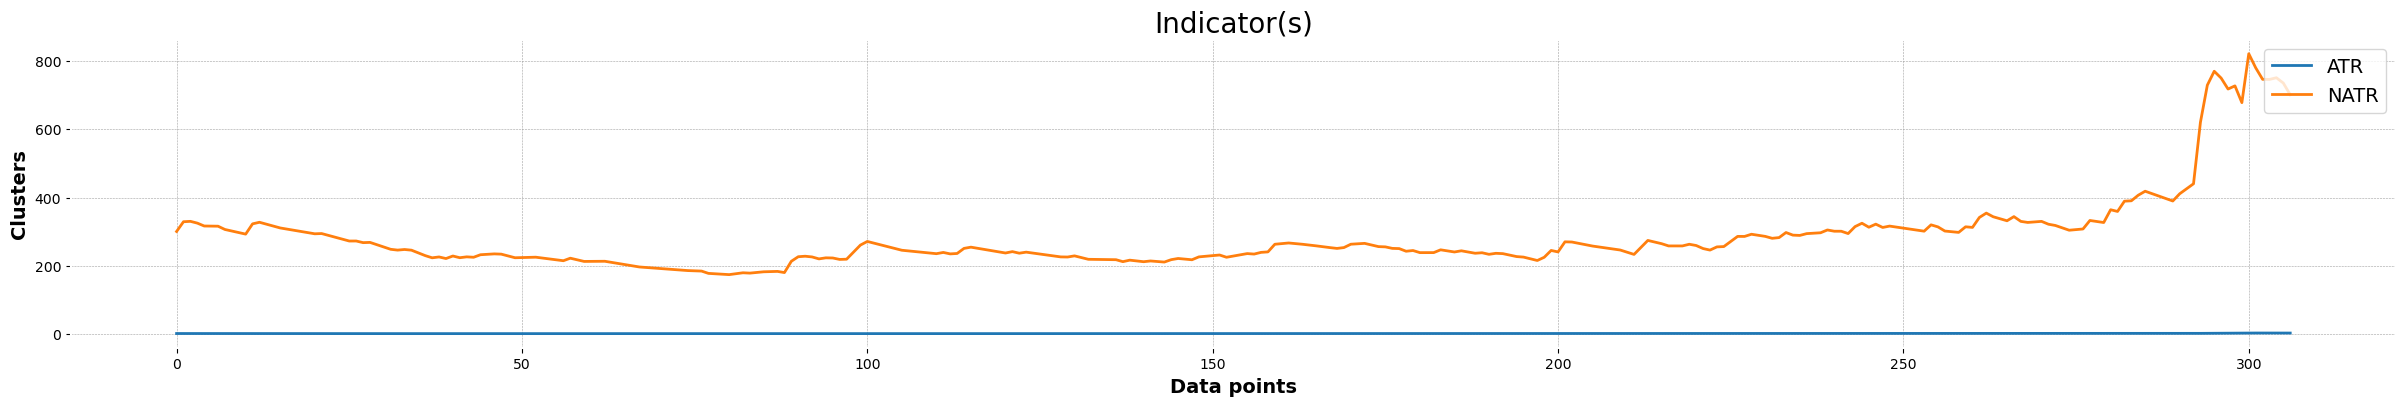

In [94]:
scanned_symbol = 'BJC'


# ระบุ date_start กับ date_end หรือระบุ window_chart อย่างใดอย่างหนึ่ง
date_start = '2018-01-01' # example: 20200101 format is YYYYmmdd or 2020-01-01 format is YYYY-mm-dd
date_end = '2022-12-31' # example: 20200131 format is YYYYmmdd or 2020-01-31 format is YYYY-mm-dd
window_chart = 2000 # candles

chart_width = 30 # ระบุความกว้า่ง
chart_height = 10 # ระบุความสูง

# Get sub data
df = data_range(symbols[scanned_symbol], from_date=date_start, to_date=date_end, window=window_chart)
new_total_rows = df.shape[0]


df_ohlc = pd.DataFrame()
df_ohlc['DATETIME'] = df['DATETIME']
df_ohlc['Open'] = df['OPEN']
df_ohlc['High'] = df['HIGH']
df_ohlc['Low'] = df['LOW']
df_ohlc['Close'] = df['CLOSE']

# Get sub data
df_ohlc = data_range(df_ohlc, from_date=date_start, to_date=date_end, window=window_chart)

df_ohlc['DATETIME'] = pd.to_datetime(df_ohlc['DATETIME'], format=datetime_format)
df_ohlc.set_index('DATETIME', inplace=True)
    
#===============================================================================================

# Plot candles chart

apdict_ma1 = mpf.make_addplot(df['MA1'])
apdict_ma2 = mpf.make_addplot(df['MA2'])
plot_ohlc(df_ohlc
                  , type='candle' # type='line'
                  , style='charles'
                  , title=scanned_symbol
                  , ylabel='Prices'
                  , figratio=(chart_width, chart_height)
                  , addplot=[apdict_ma1, apdict_ma2]
                  ,)

#===============================================================================================

def plot_indi(data, cols):    
    for i in range(0, len(cols)):
        x = np.arange(new_total_rows)
        y = data[cols[i]]
        plt.plot(x, y, label=cols[i])

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['RSI_S', 'RSI_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['MACD_S', 'MACD_SIGNAL_S'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['STOCHK_S', 'STOCHD_S', 'STOCHK_M', 'STOCHD_M'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

#===============================================================================================

# Plot indicators, features
chart_width = 30
chart_height = 4
plt.figure(figsize=(chart_width, chart_height))

plot_indi(df, ['ATR', 'NATR'])

plt.title('Indicator(s)', fontsize=20)
plt.xlabel('Data points', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

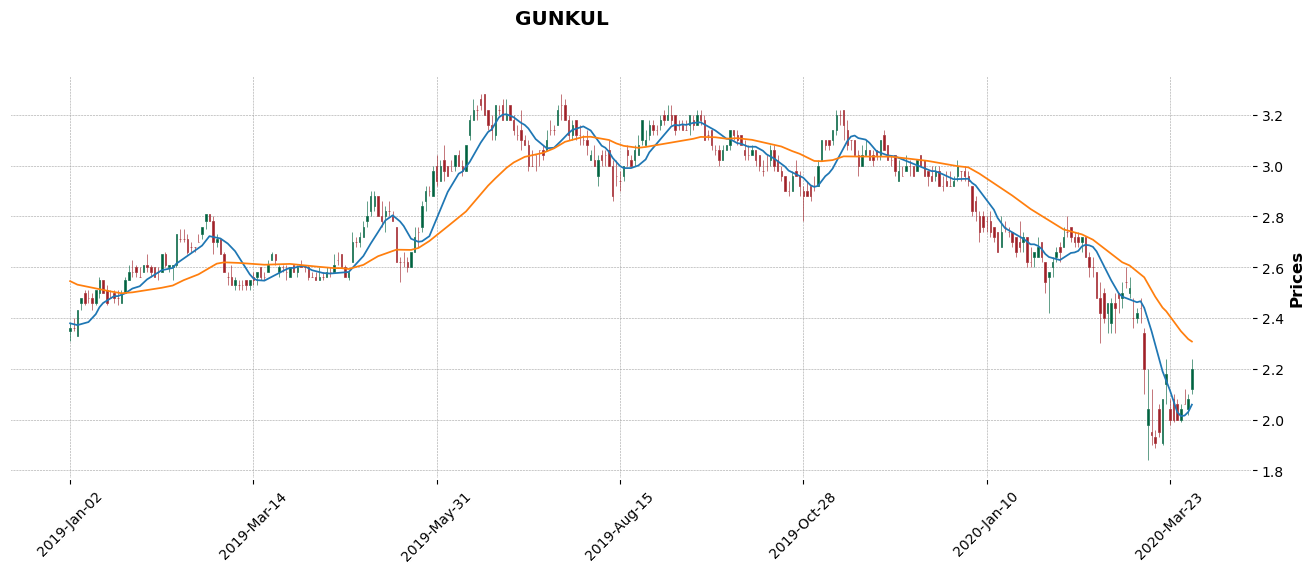

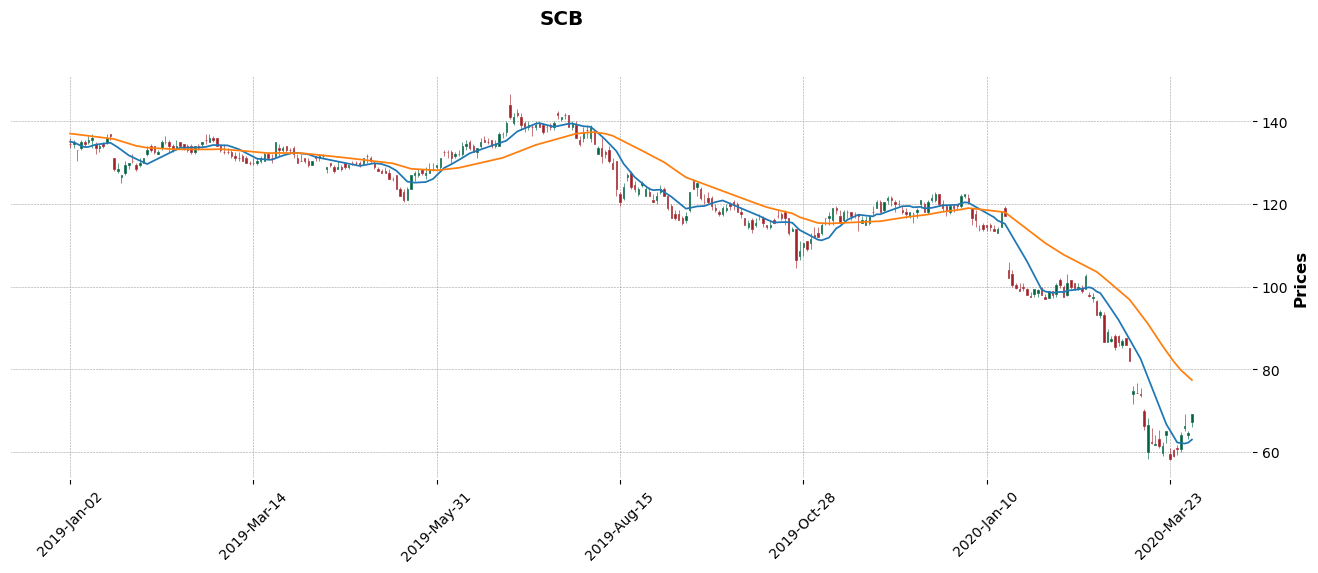

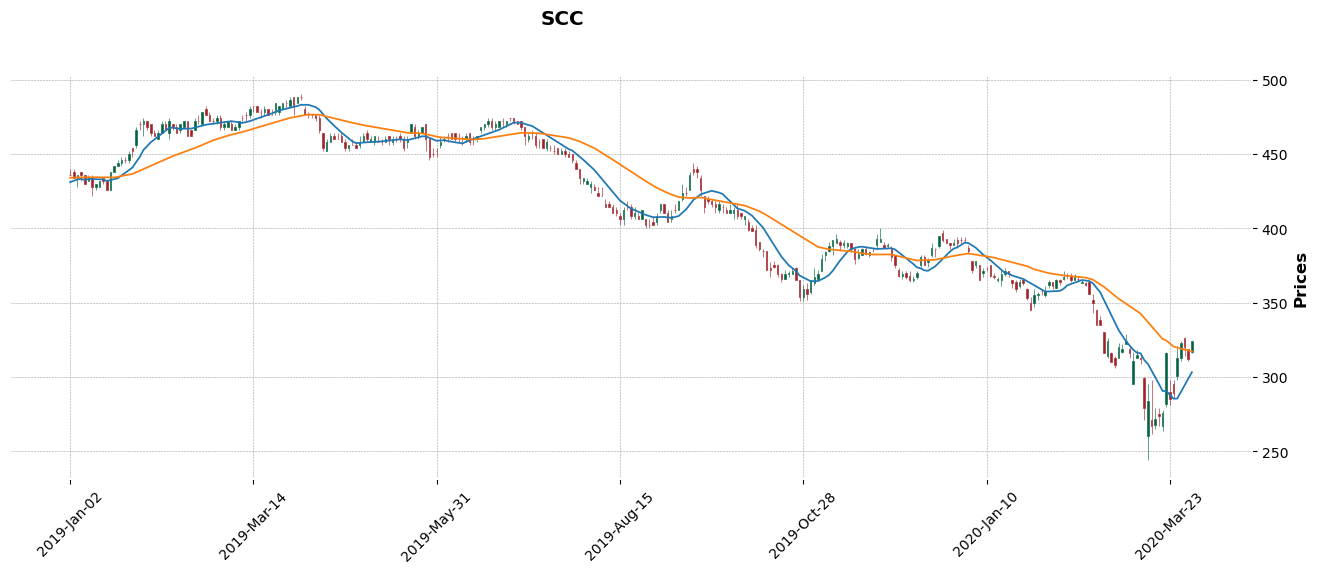

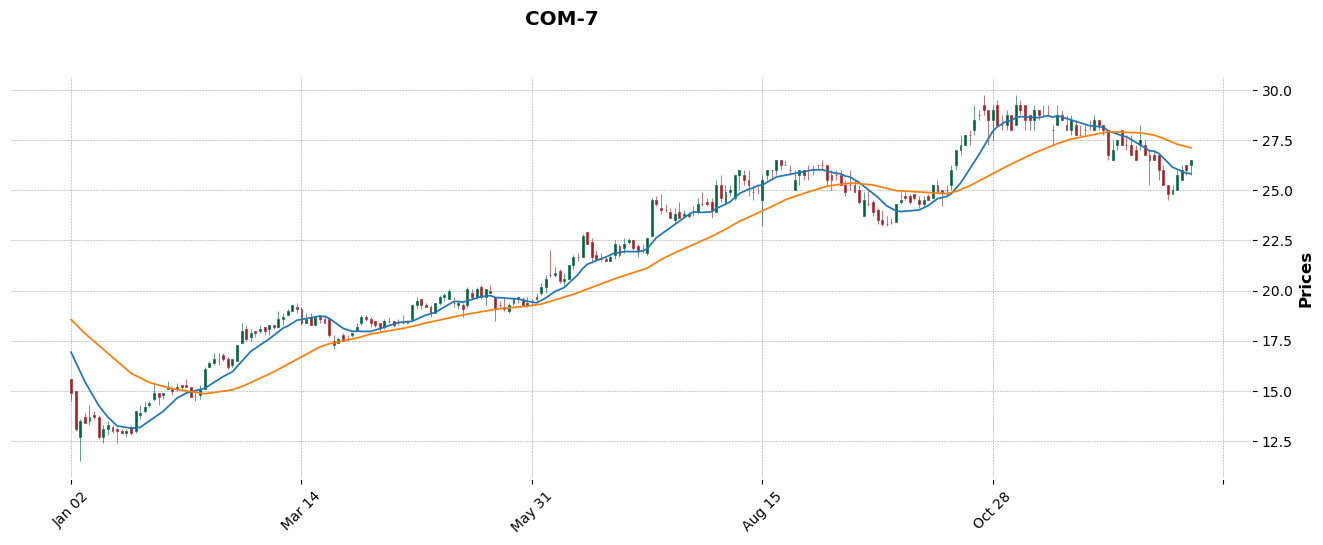

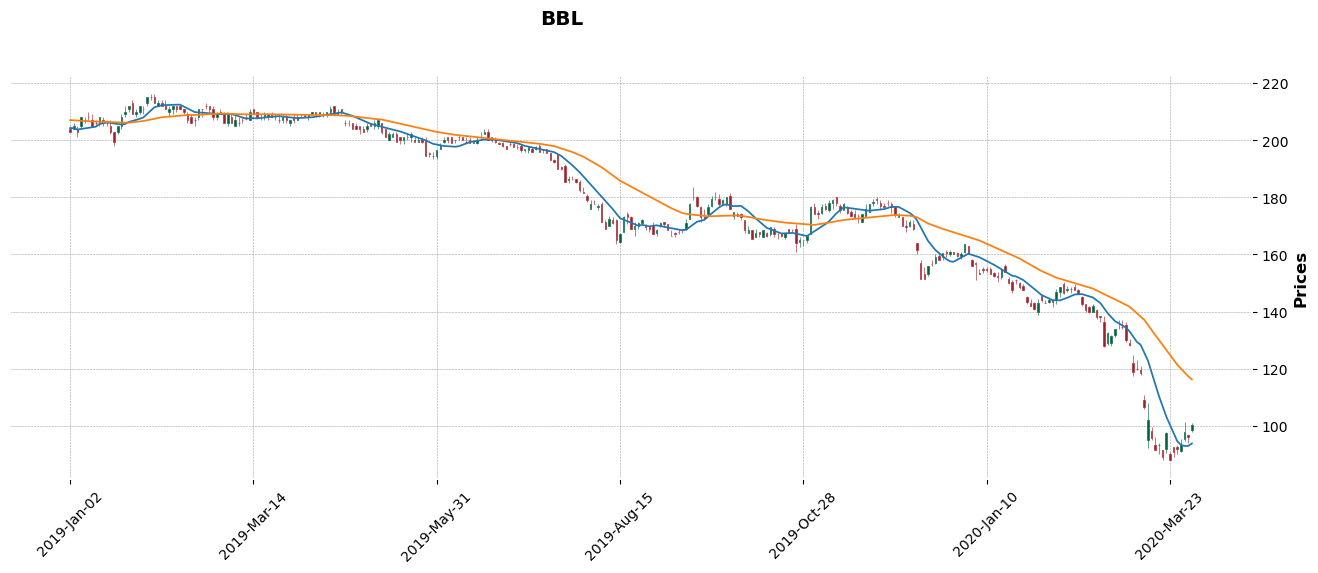

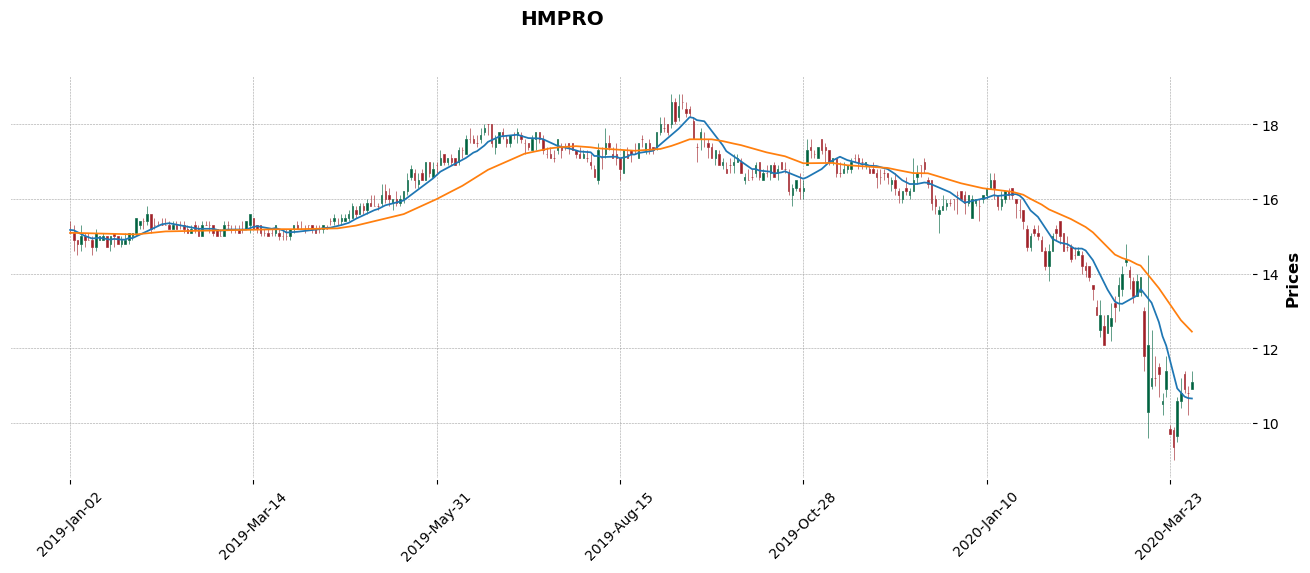

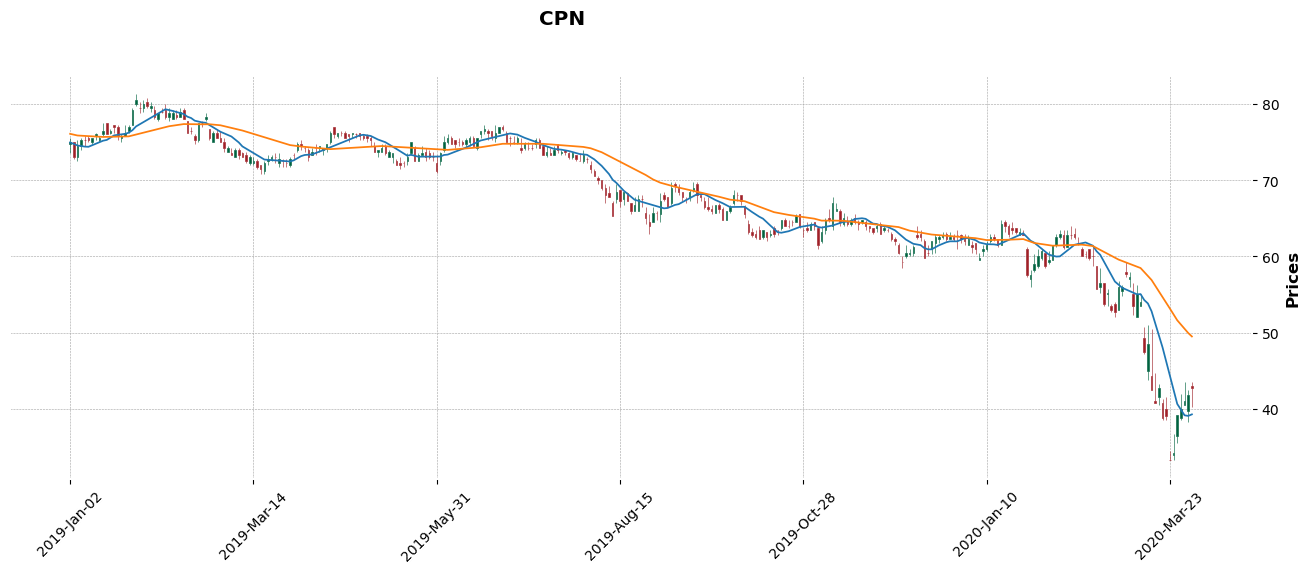

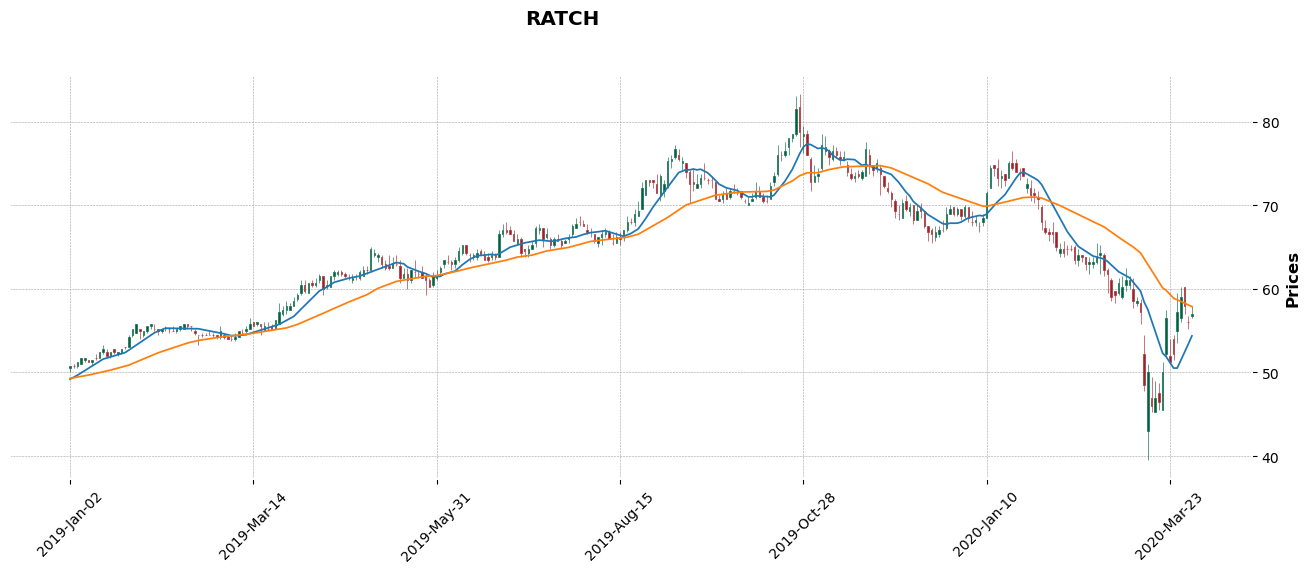

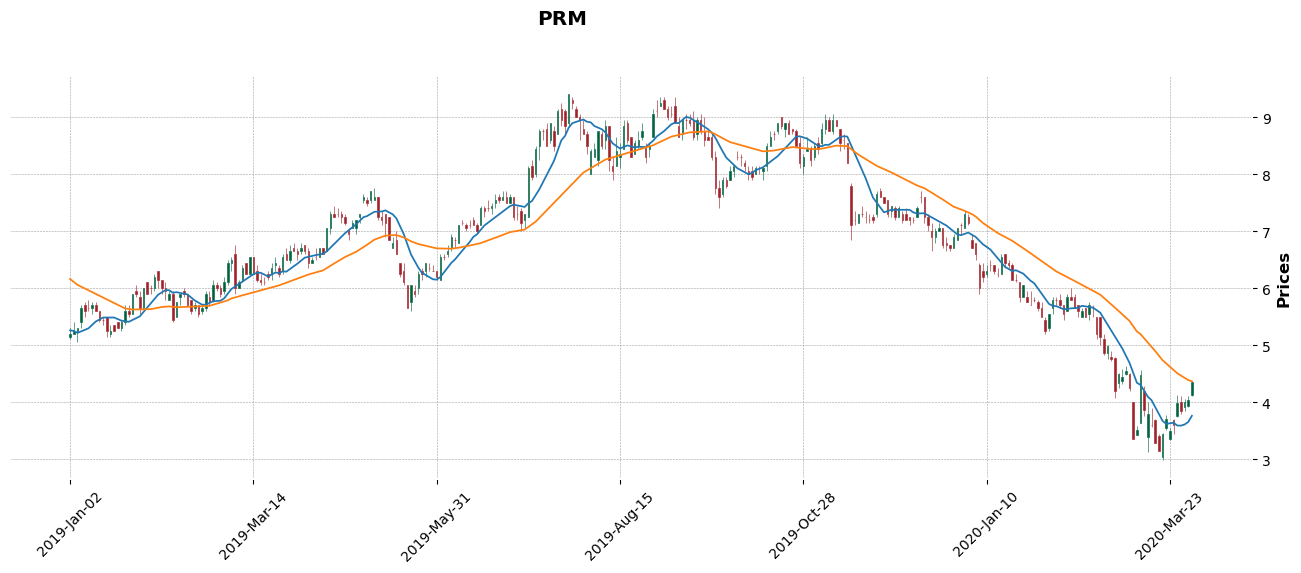

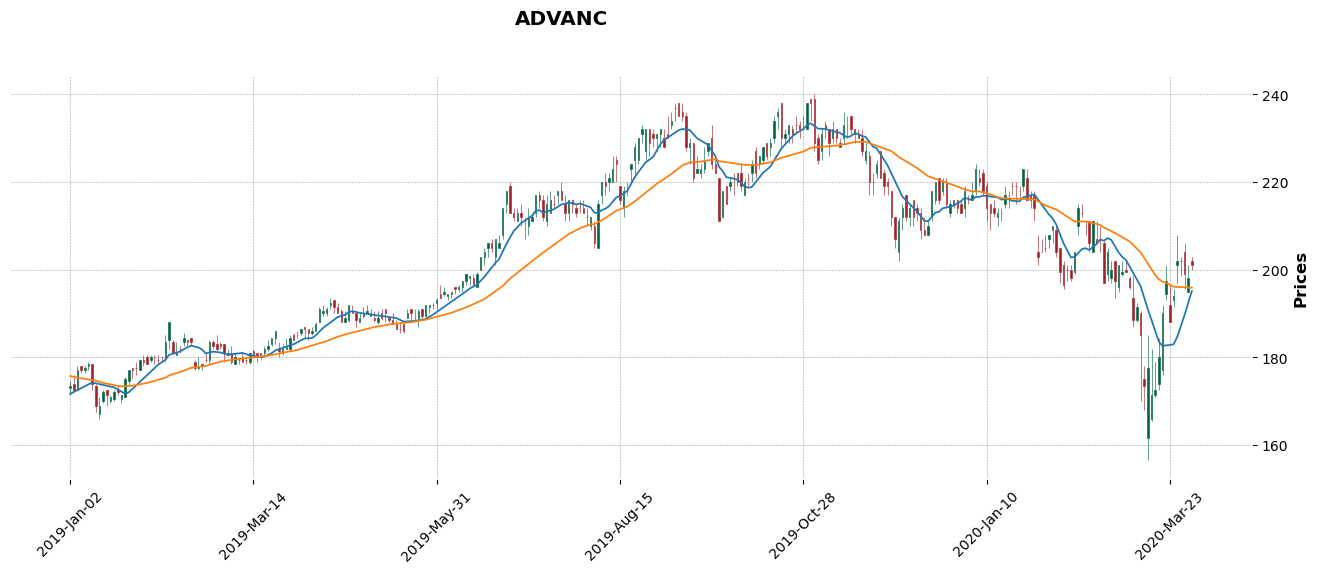

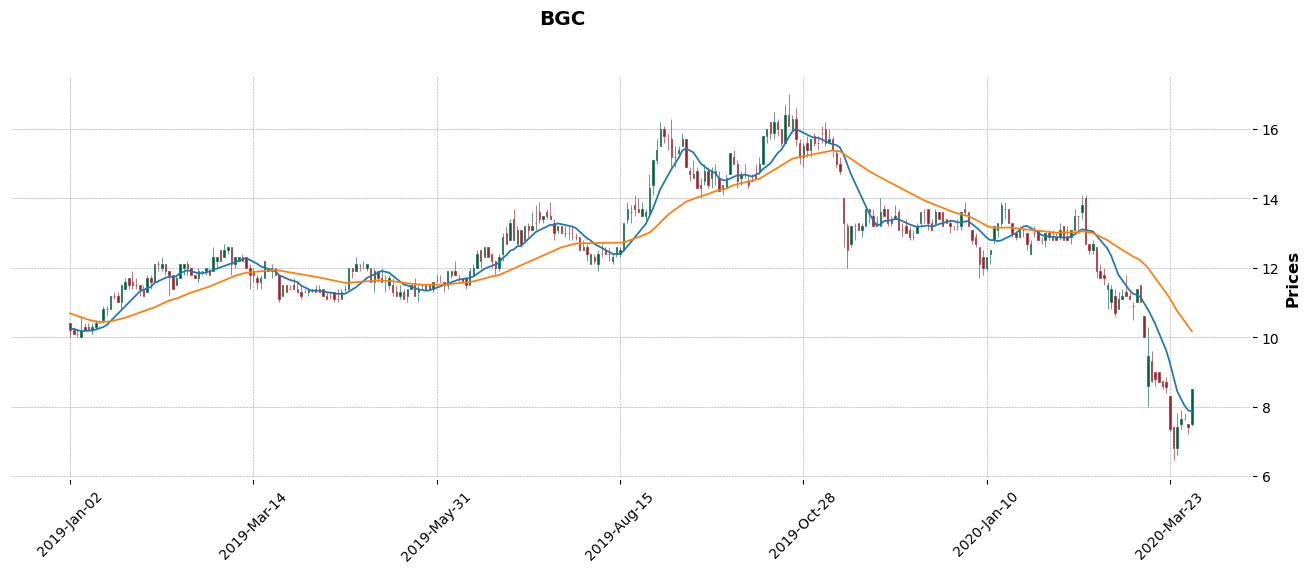

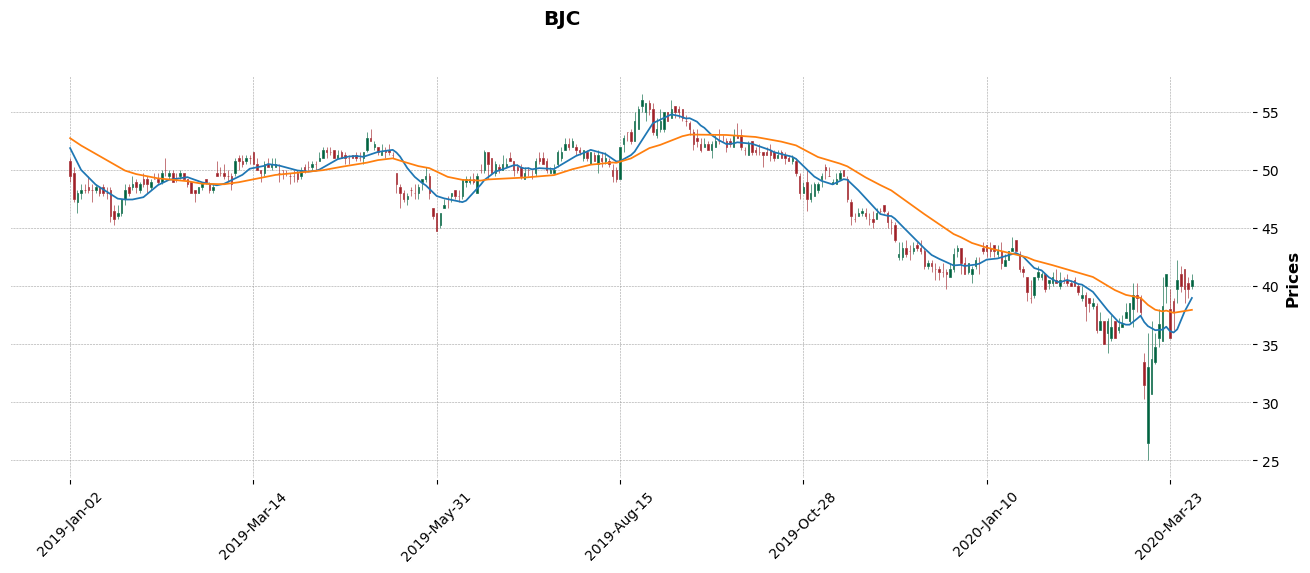

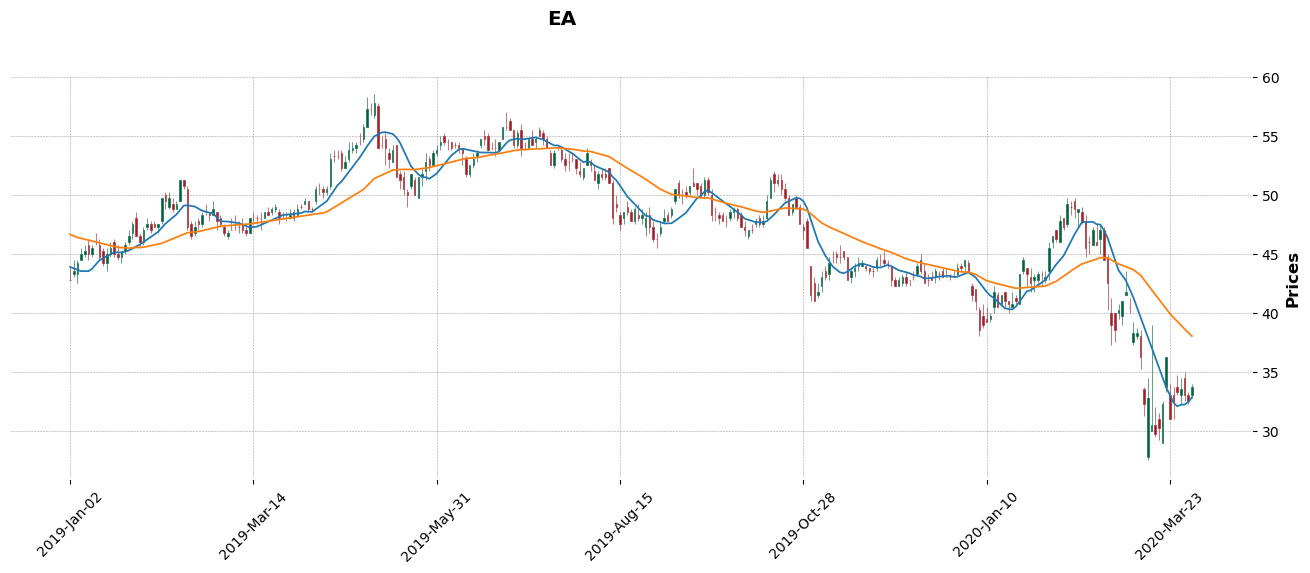

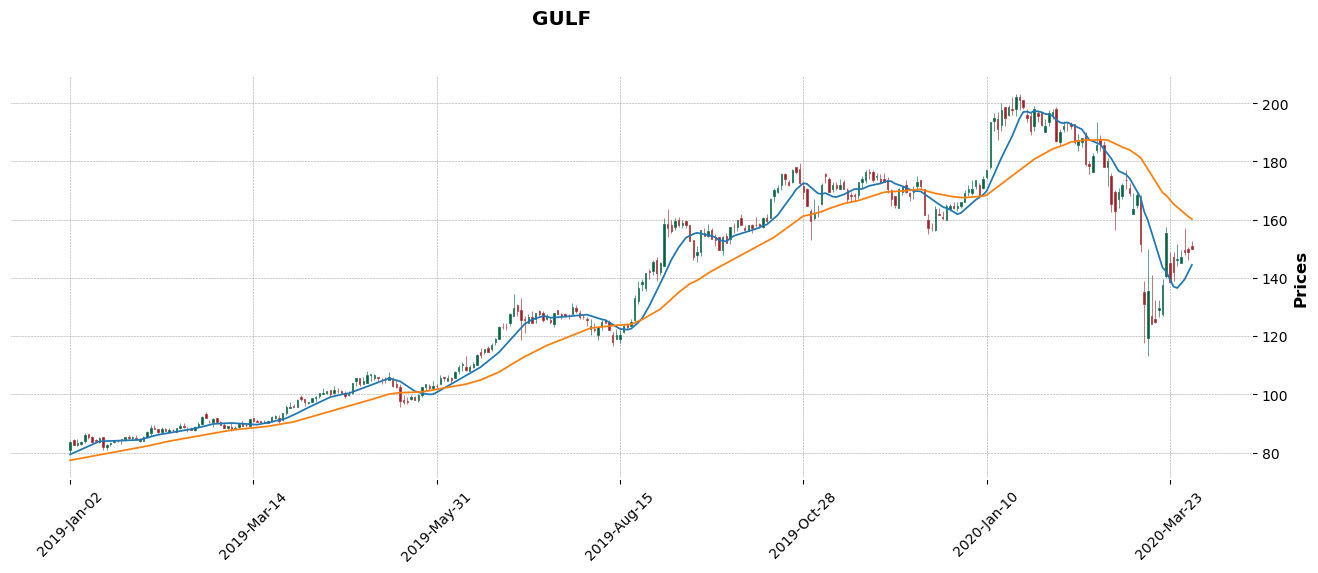

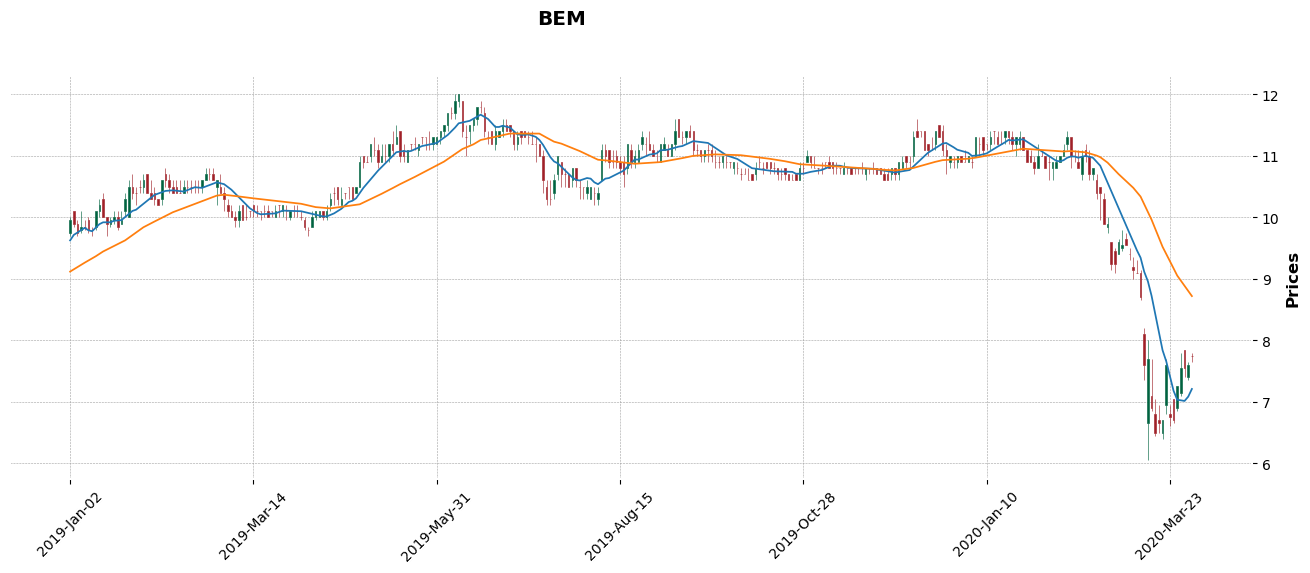

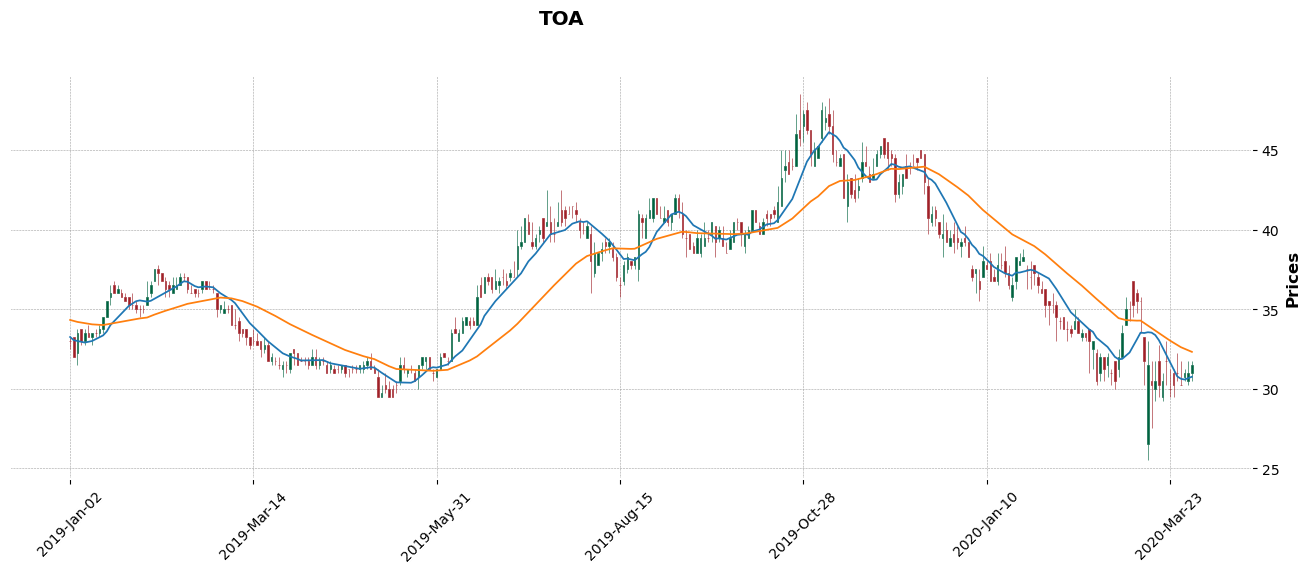

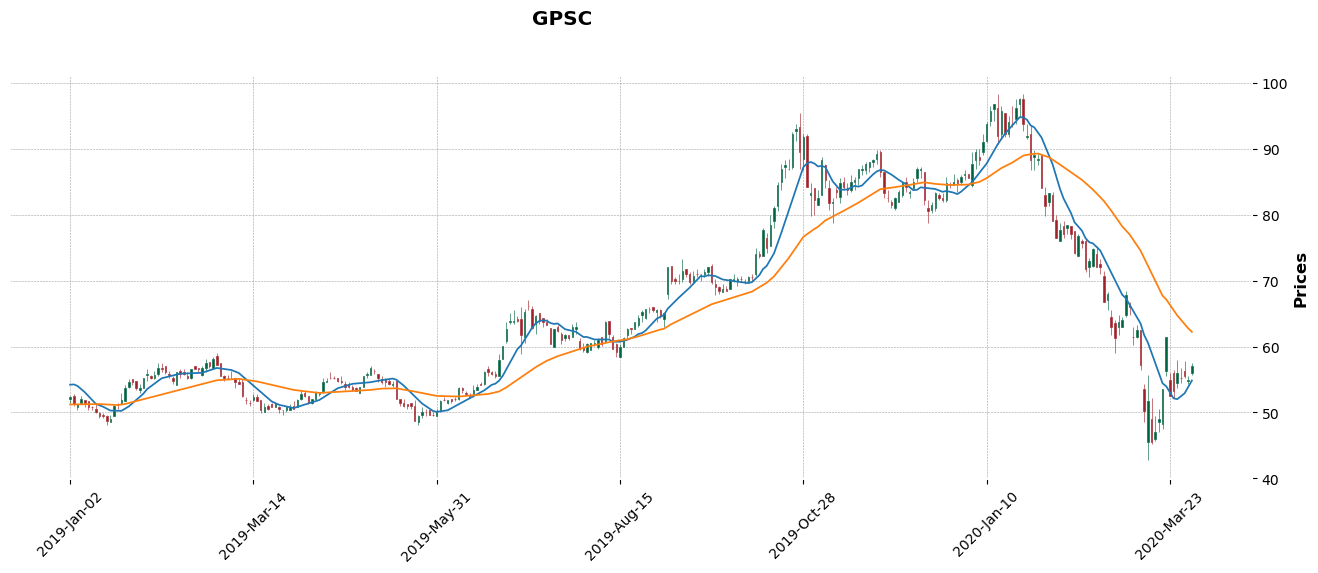

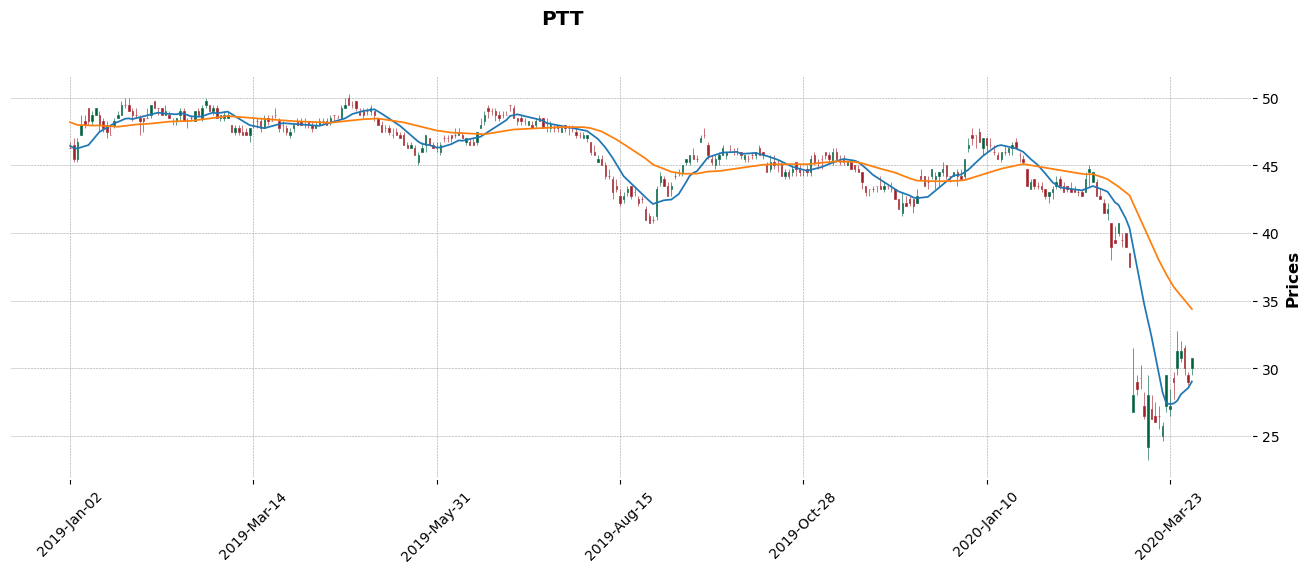

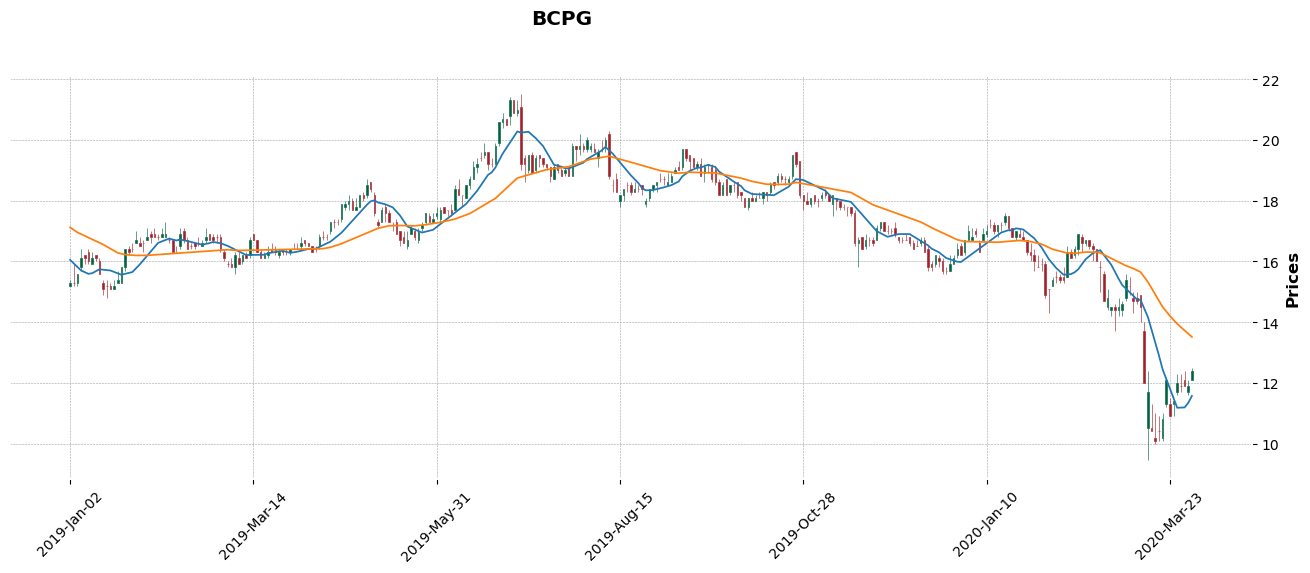

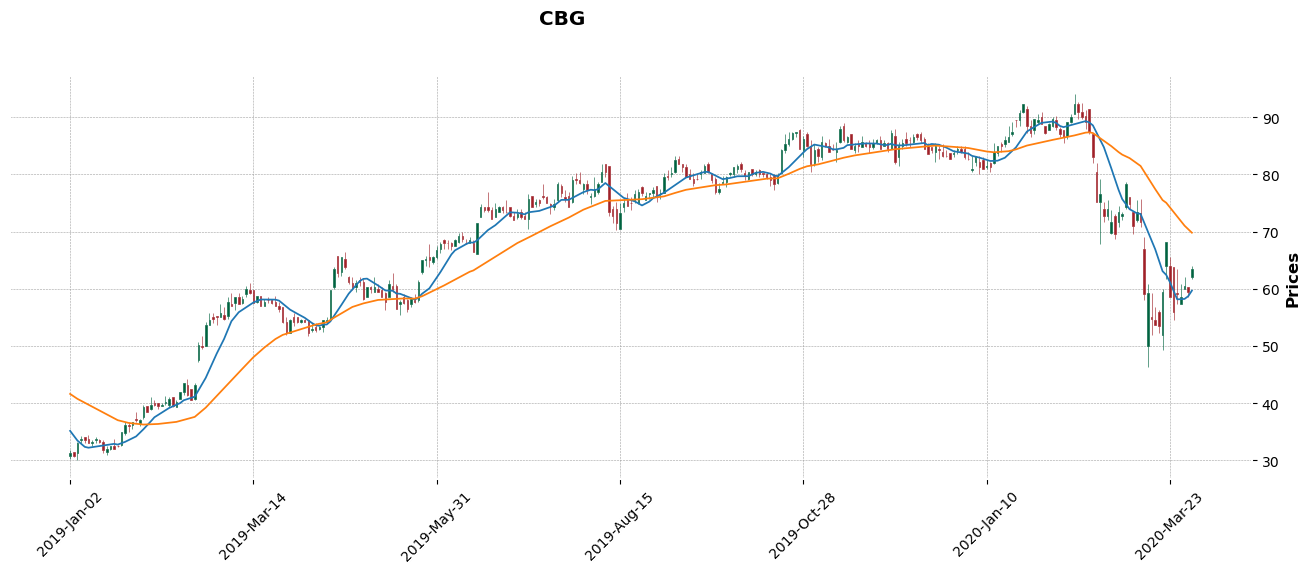

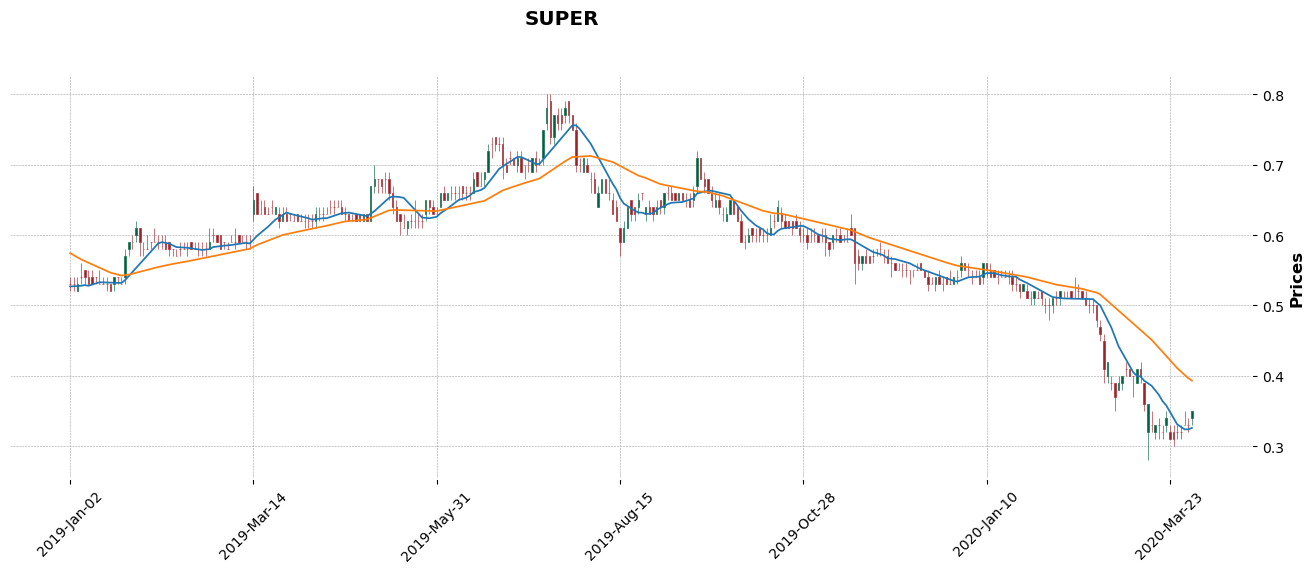

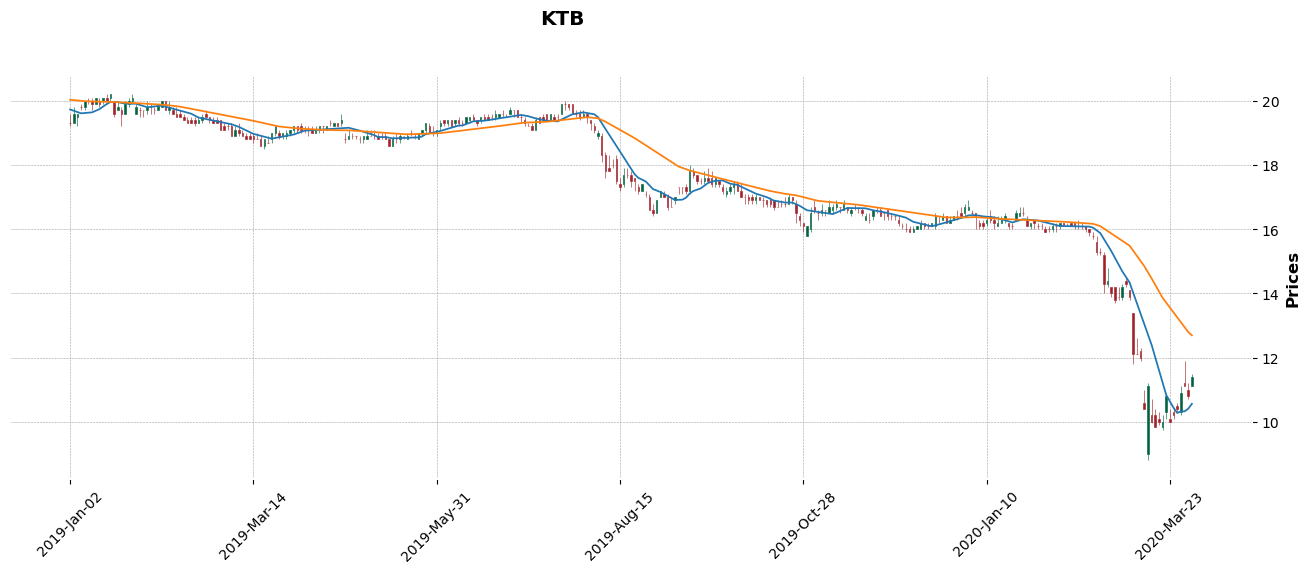

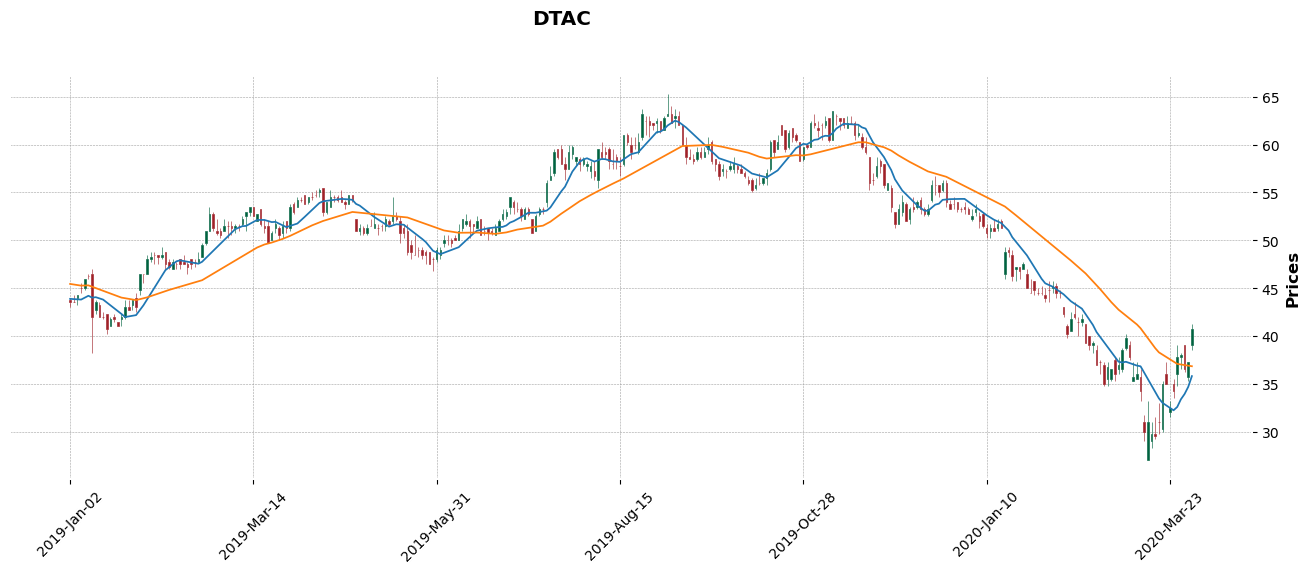

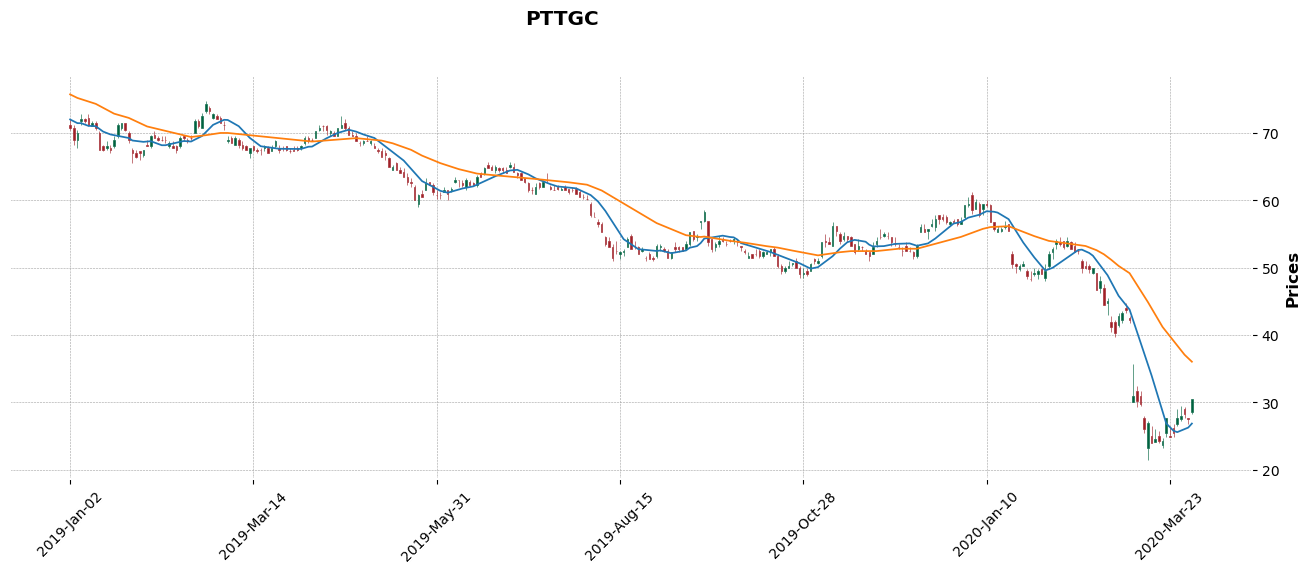

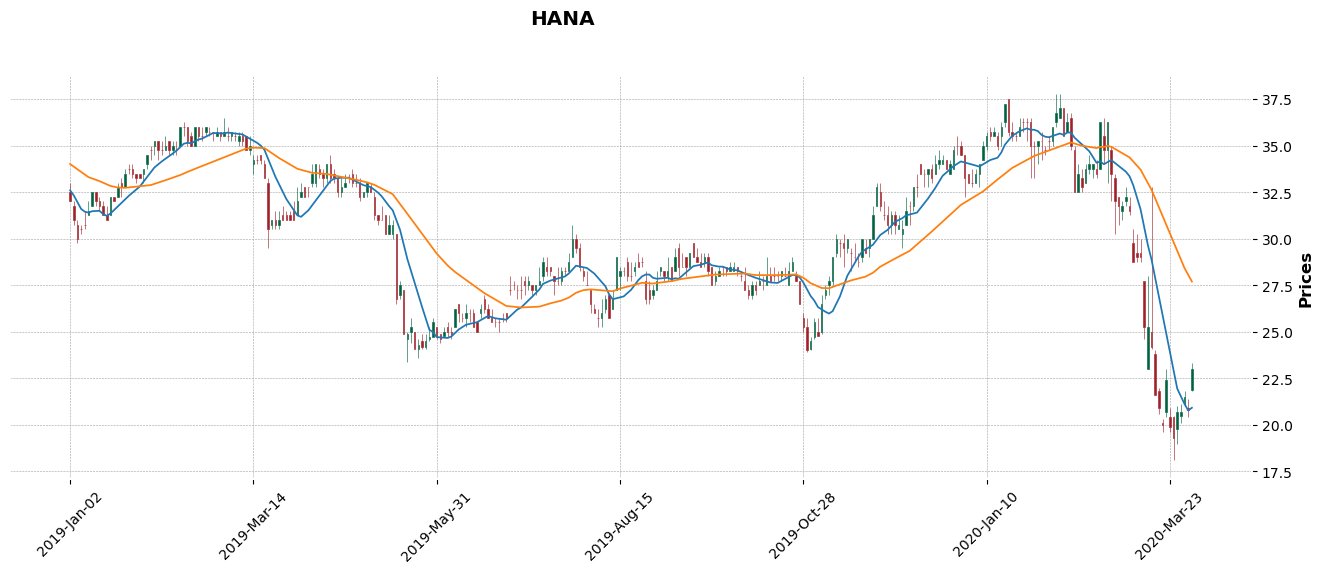

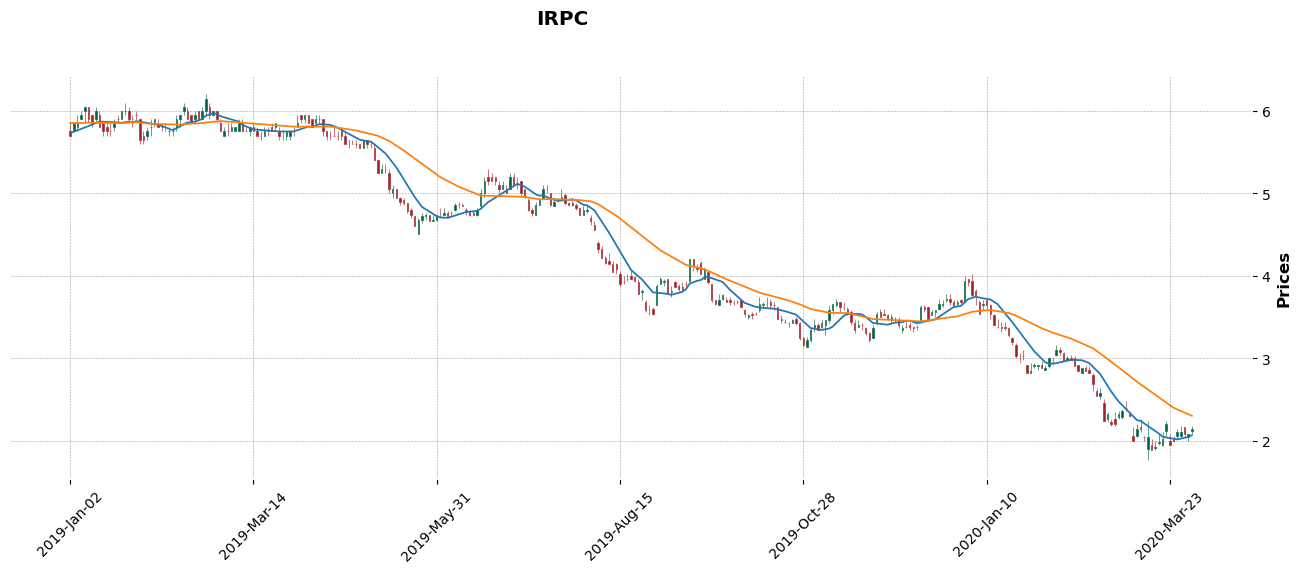

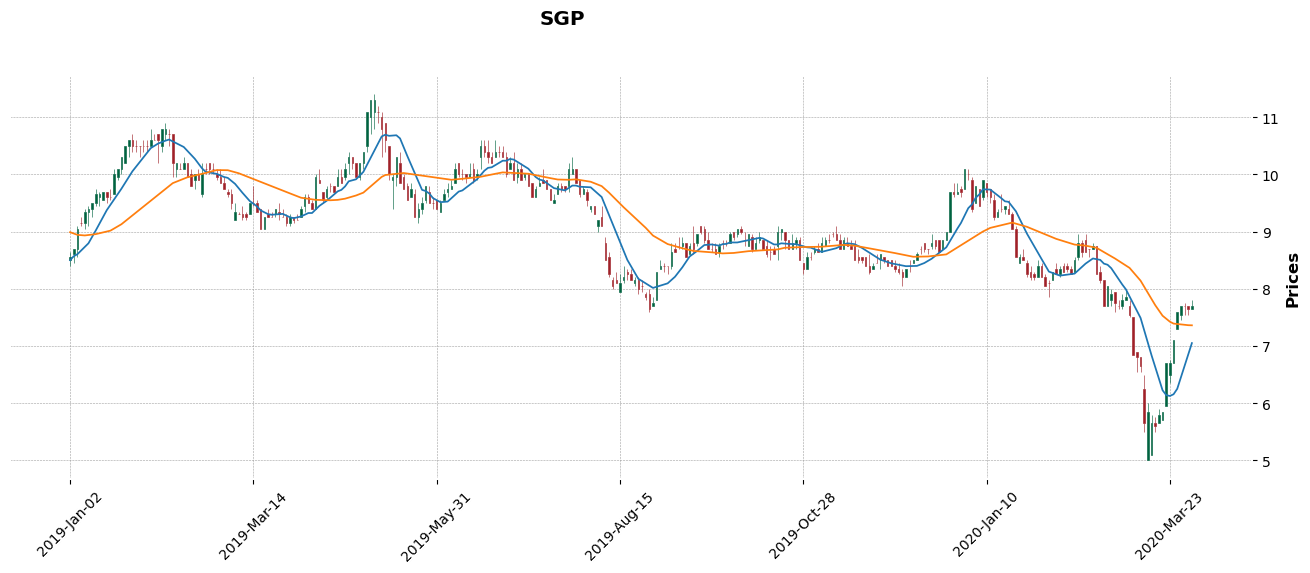

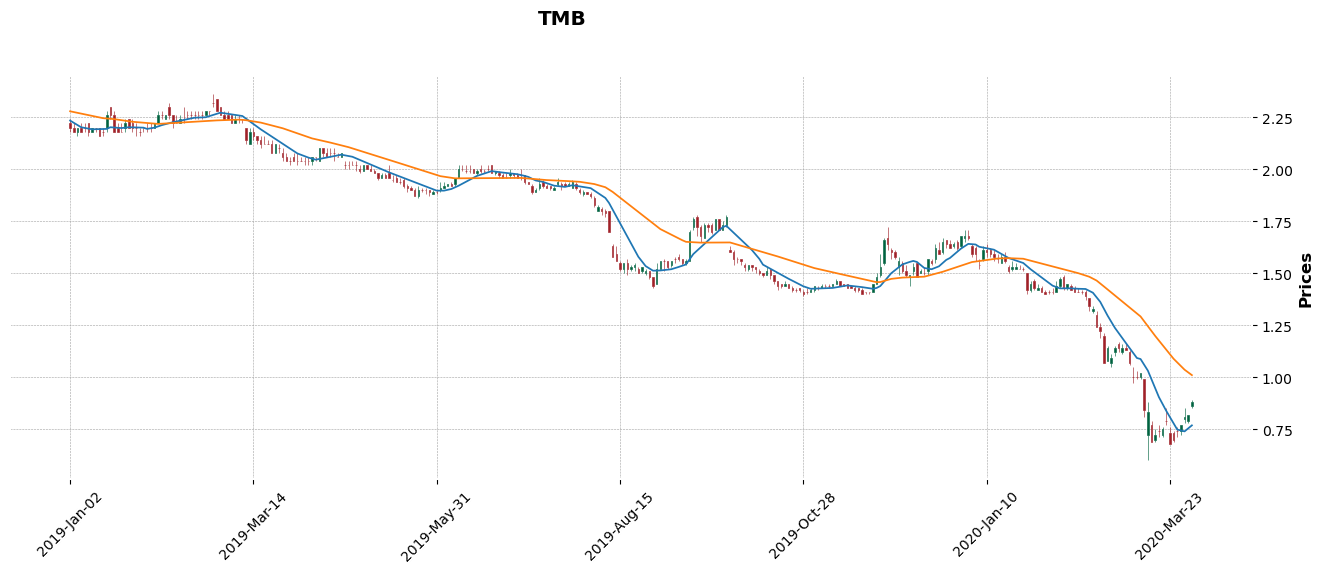

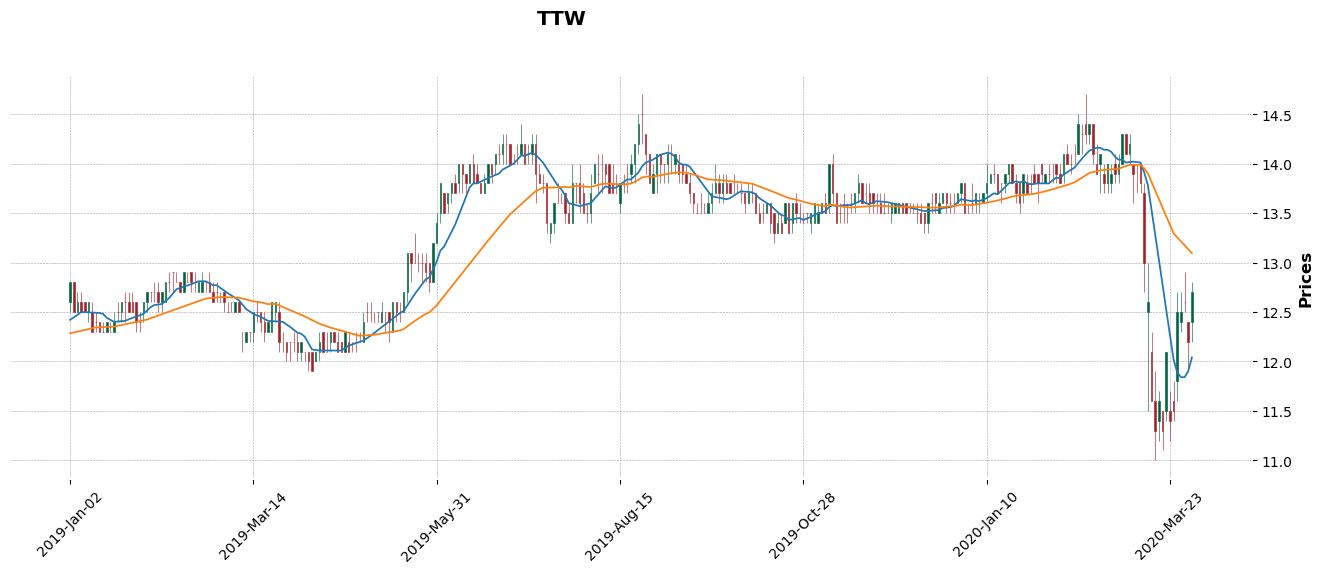

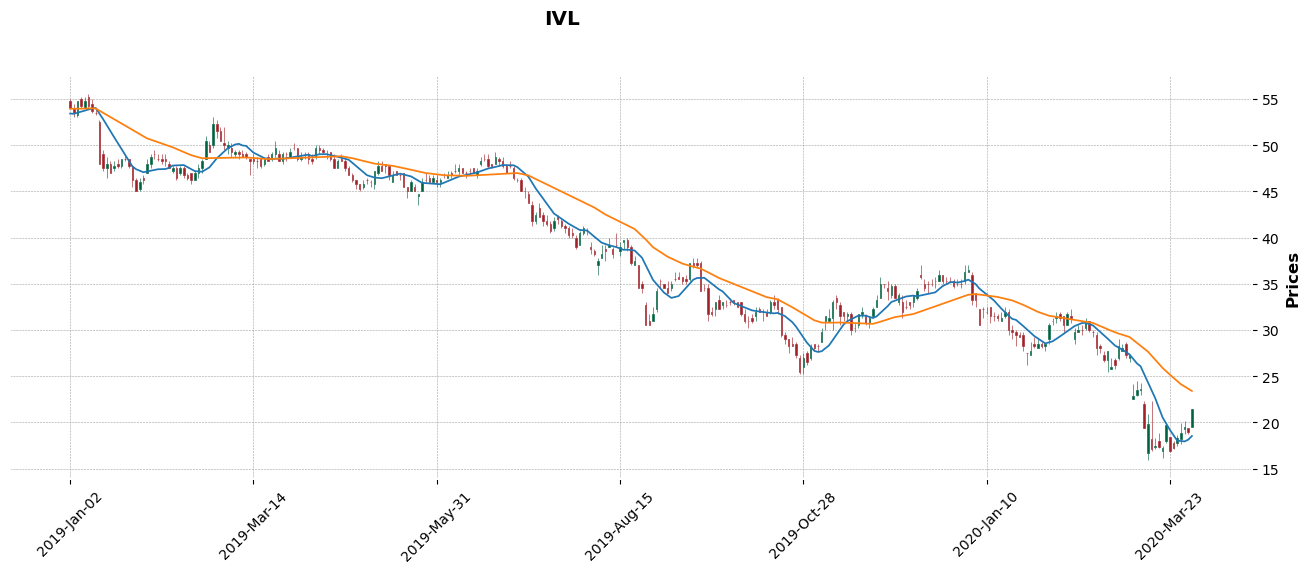

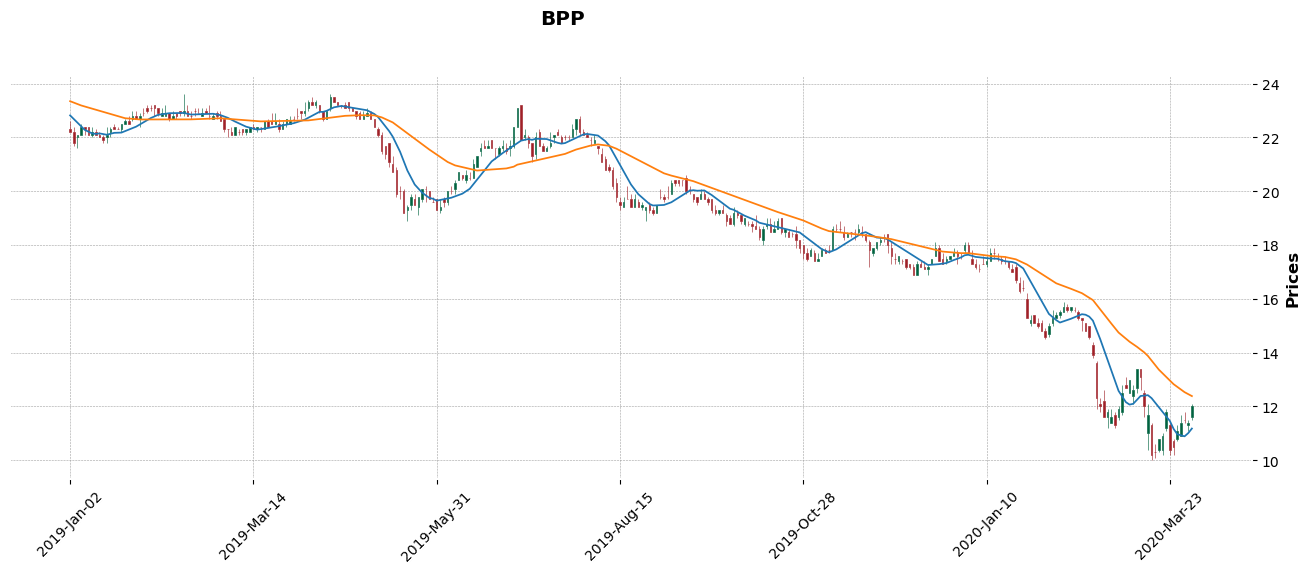

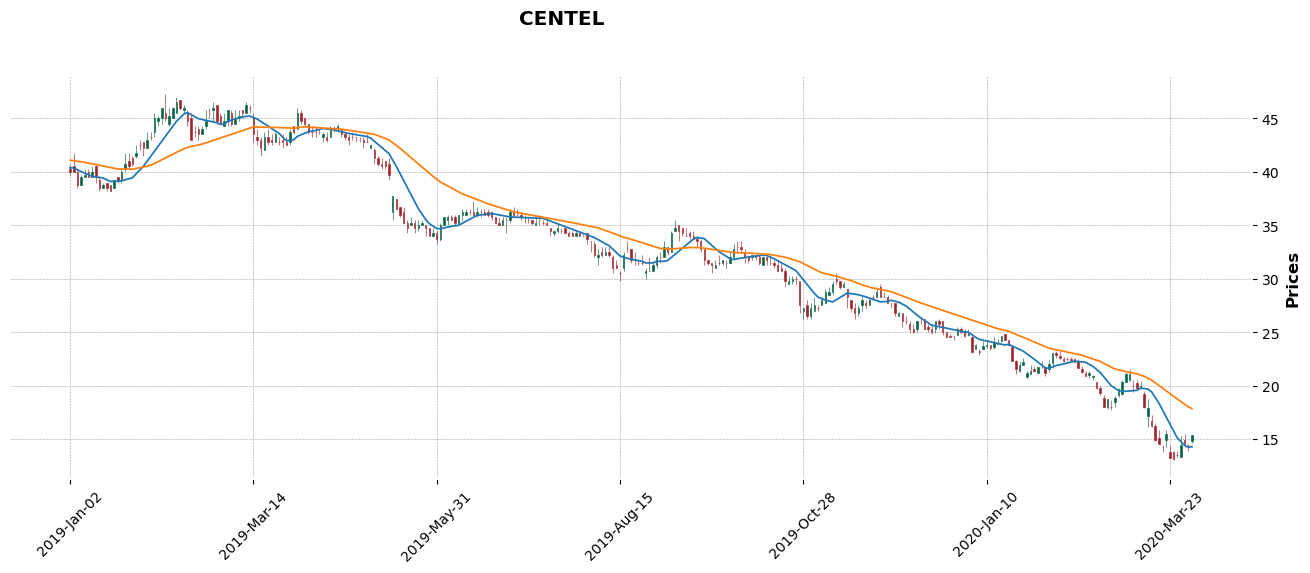

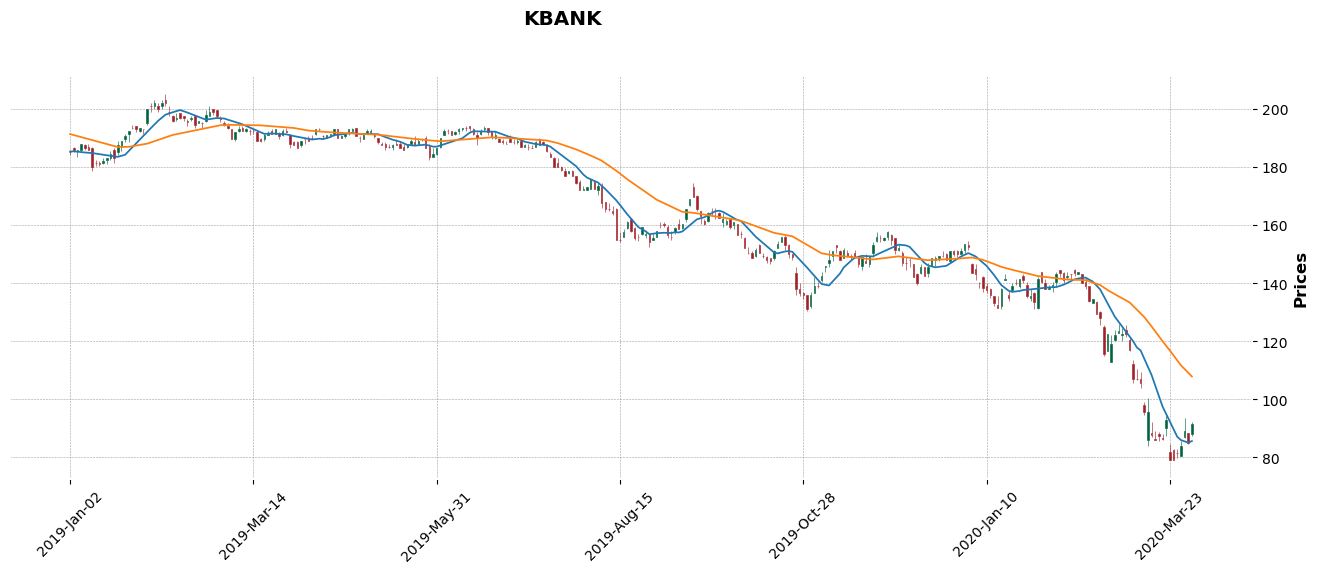

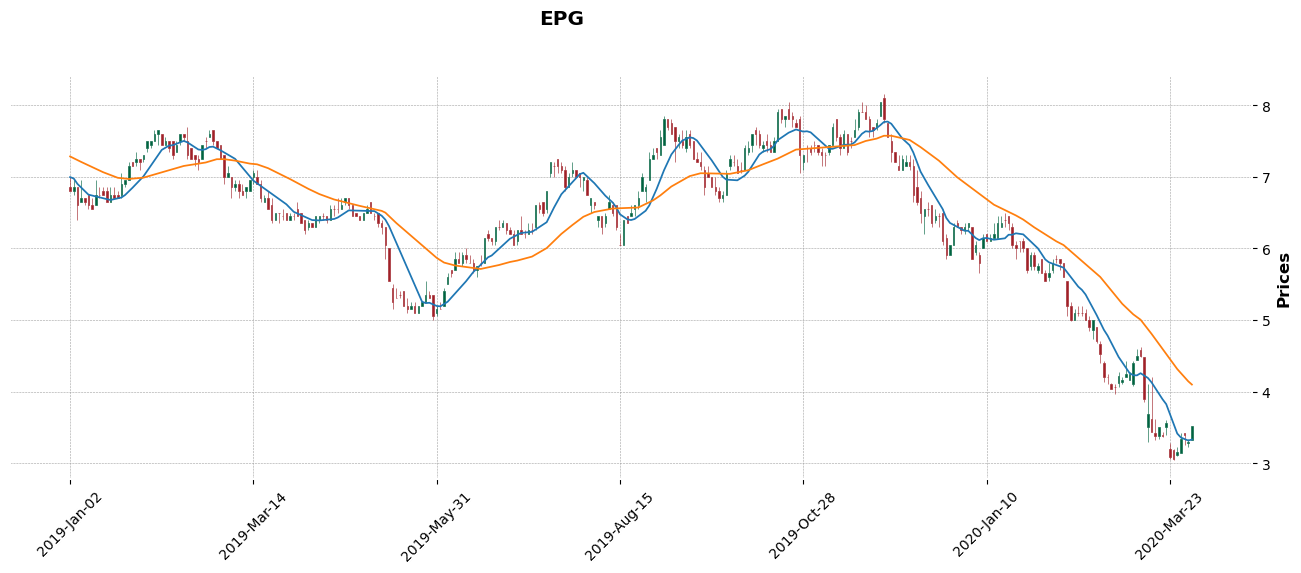

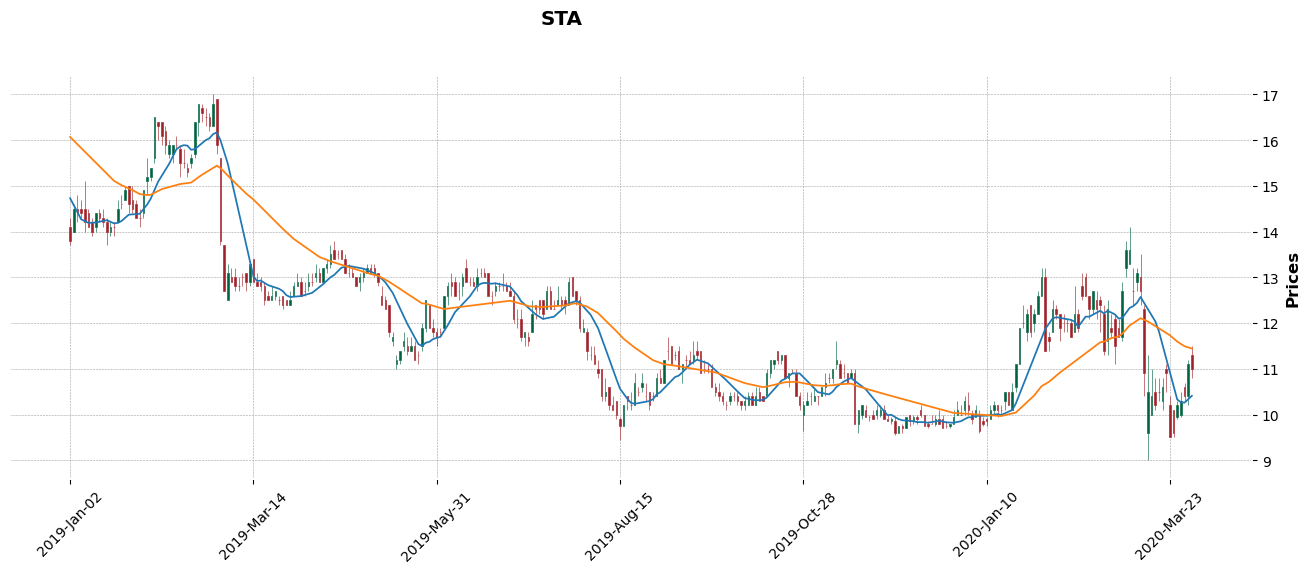

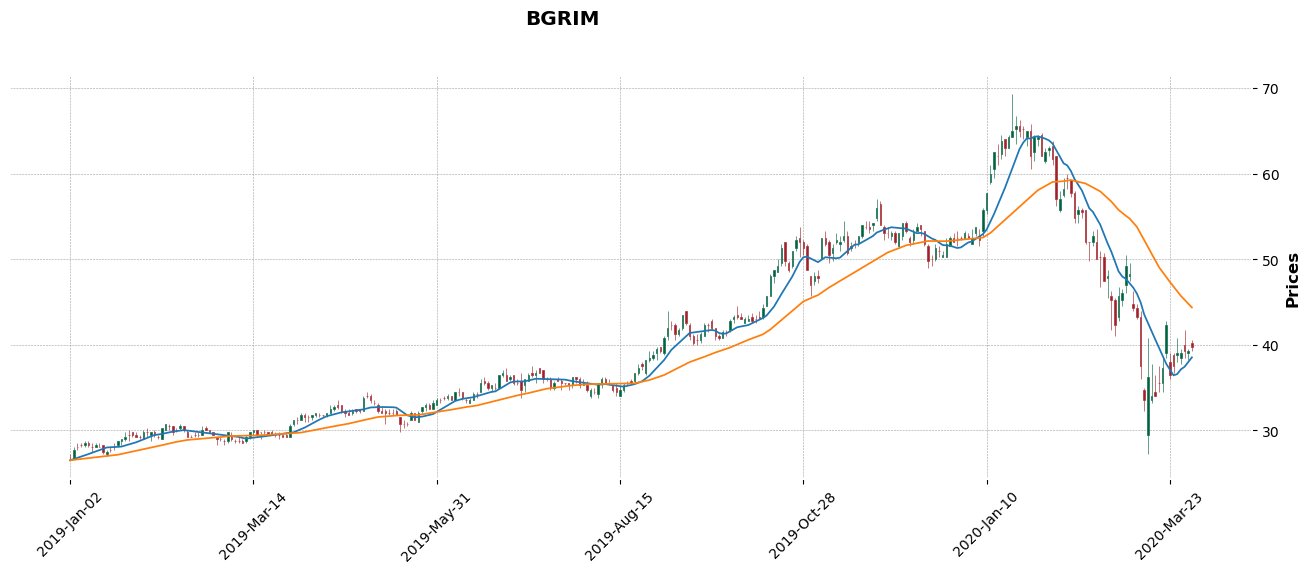

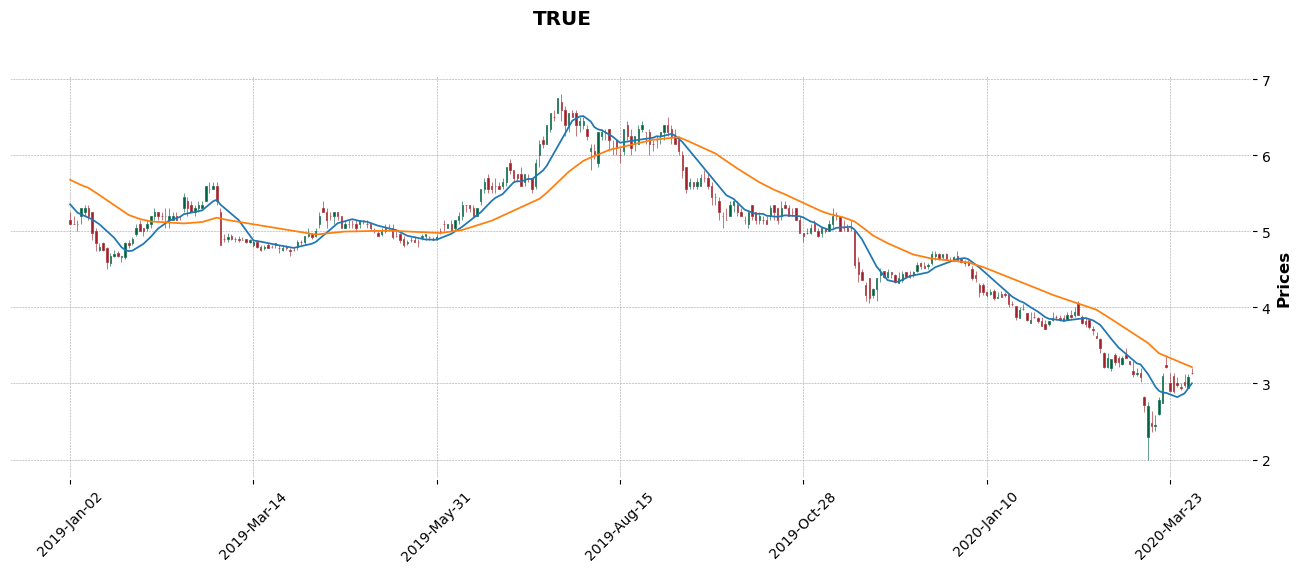

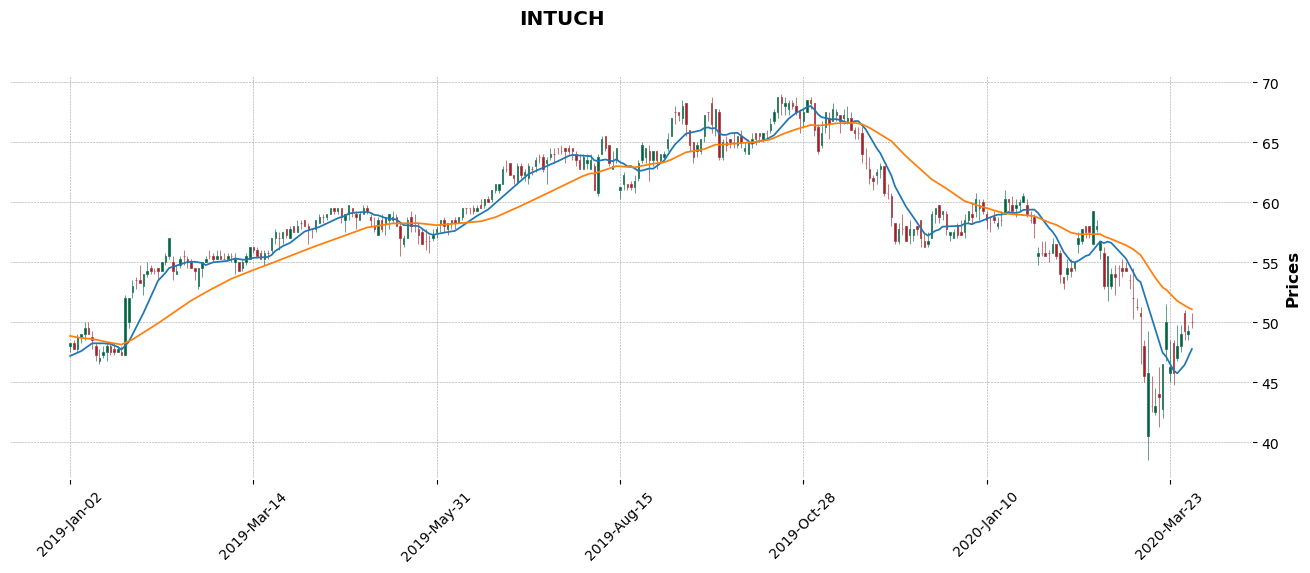

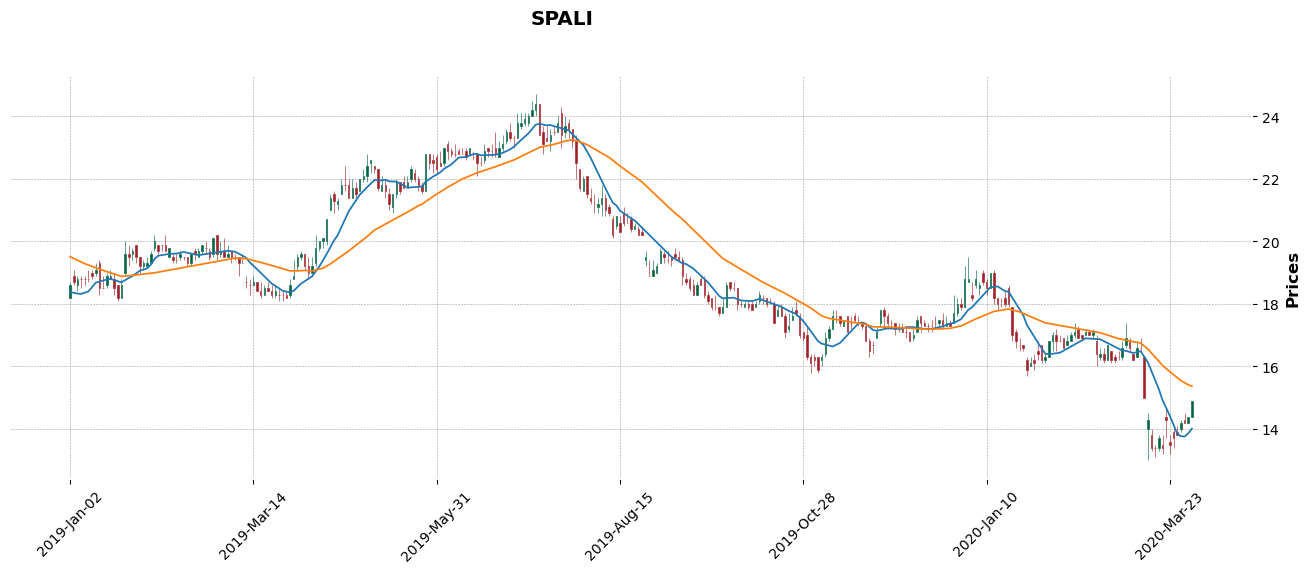

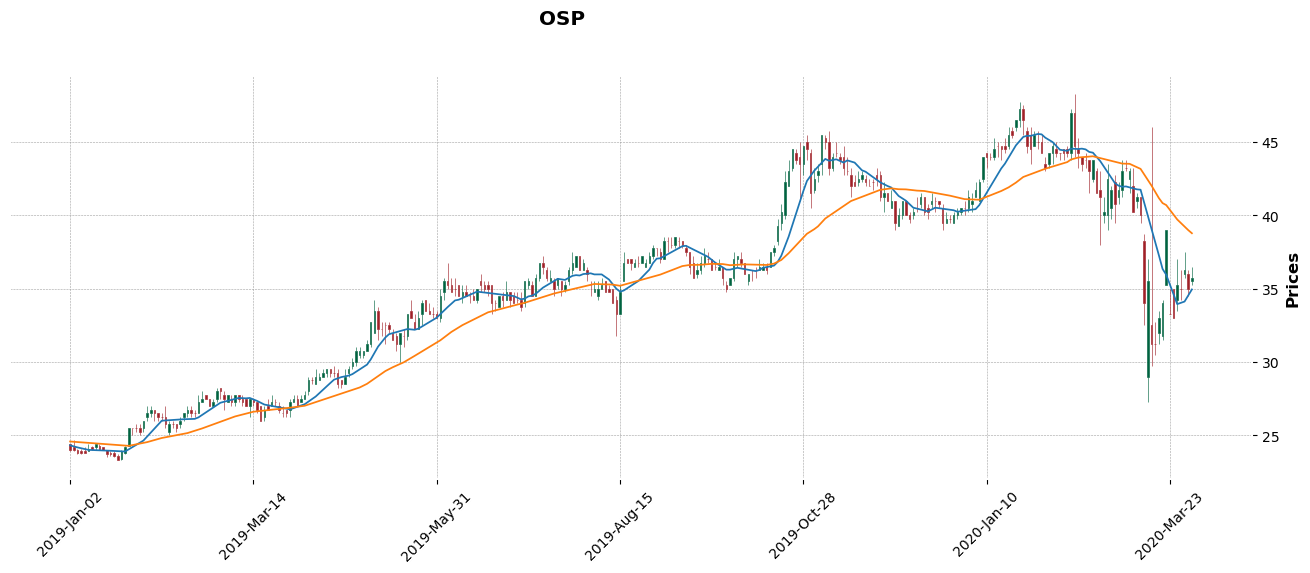

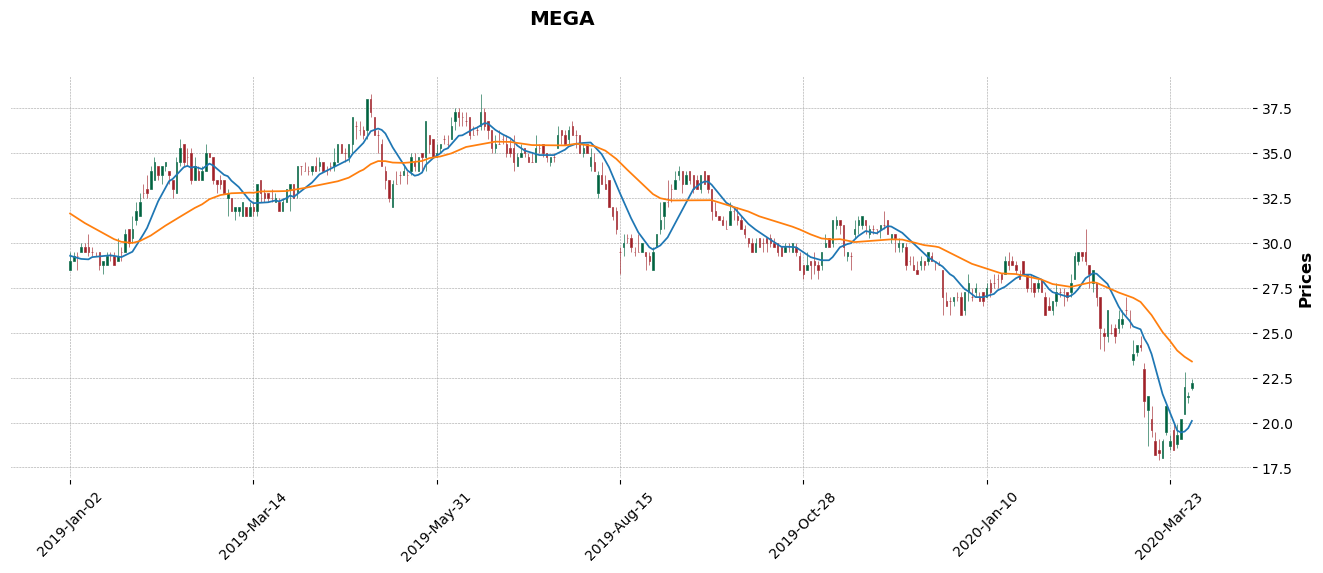

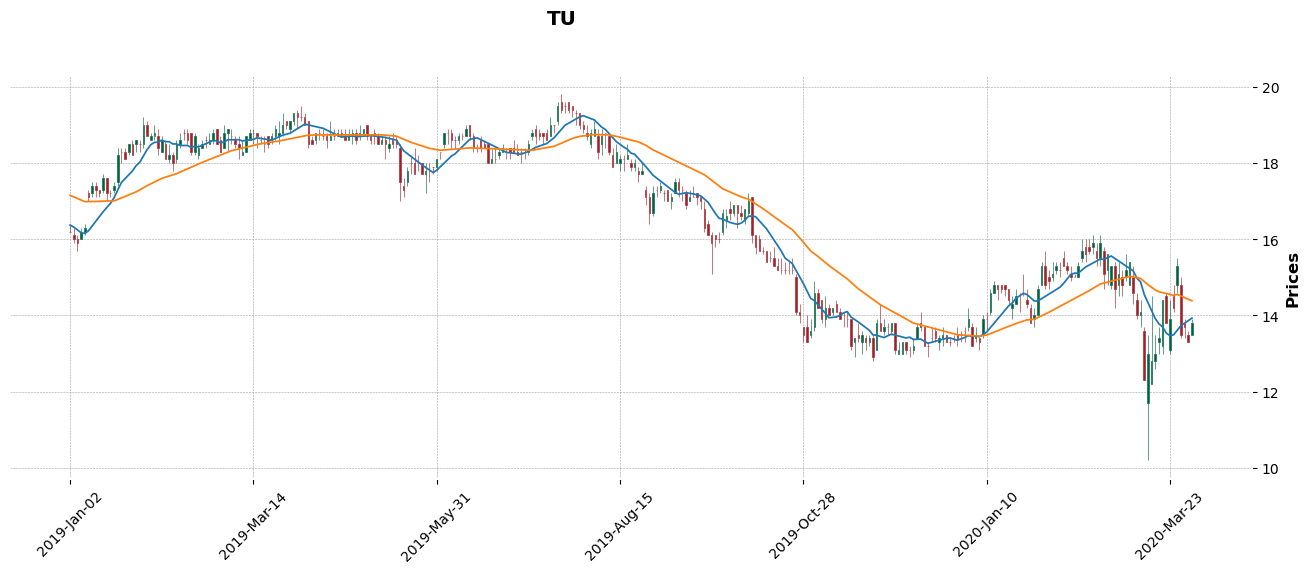

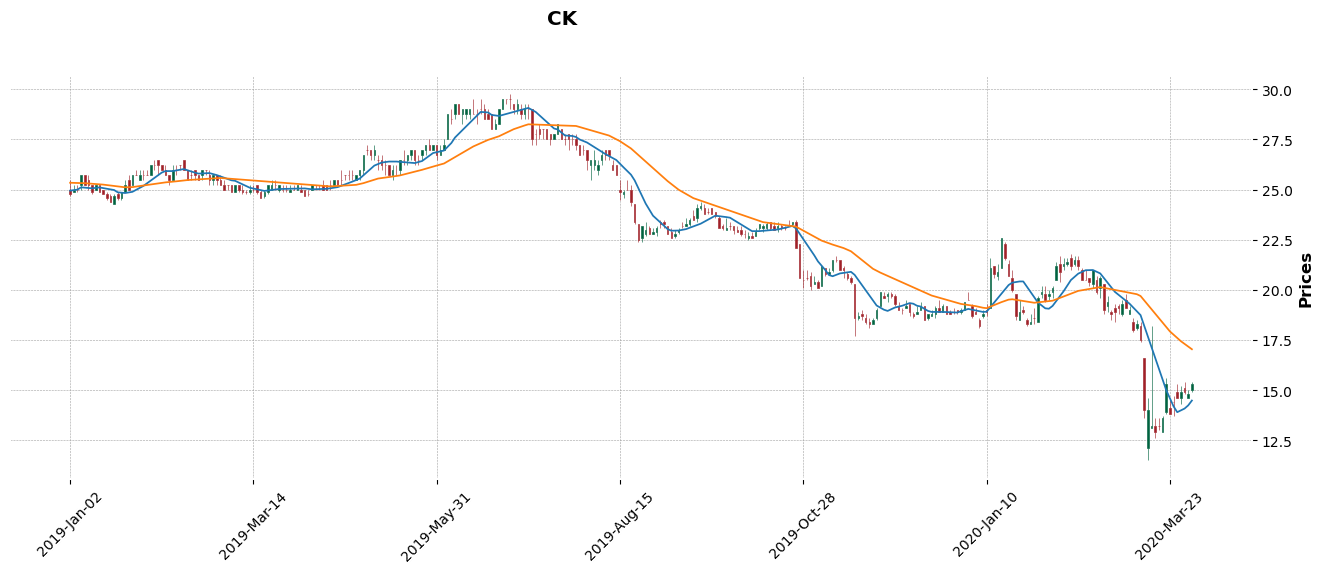

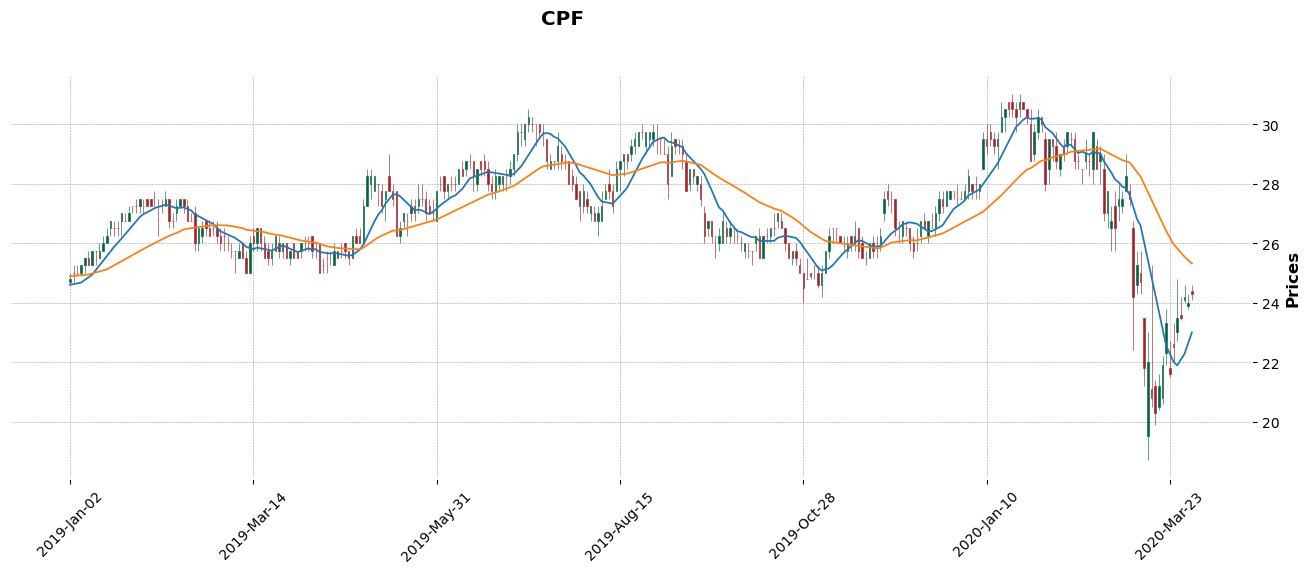

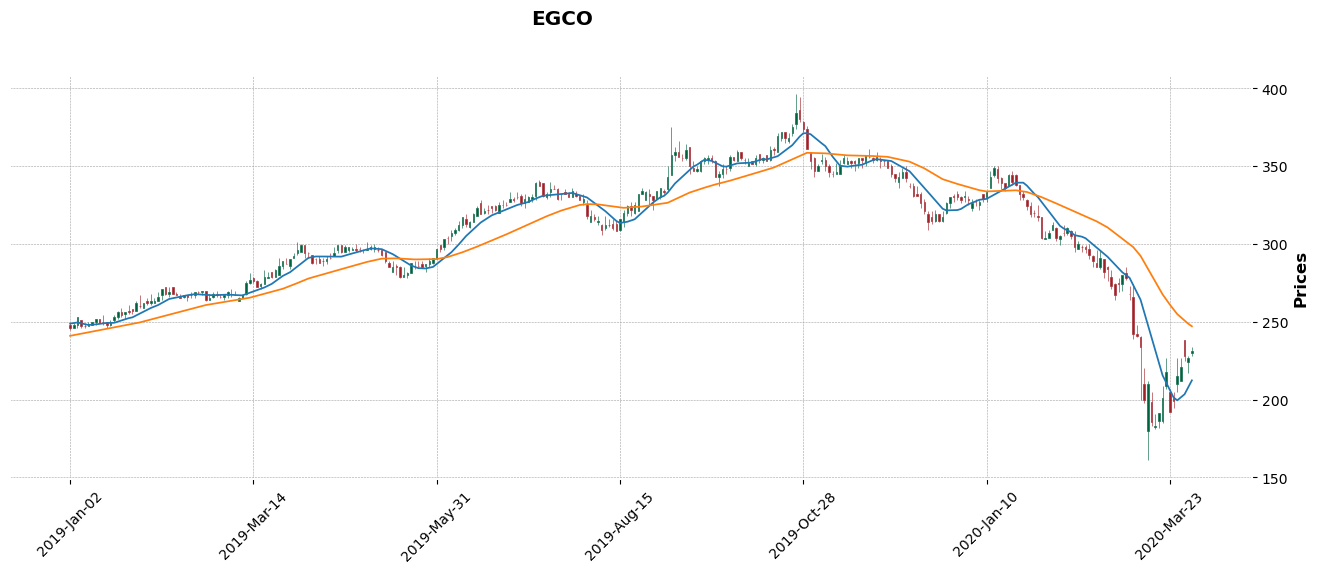

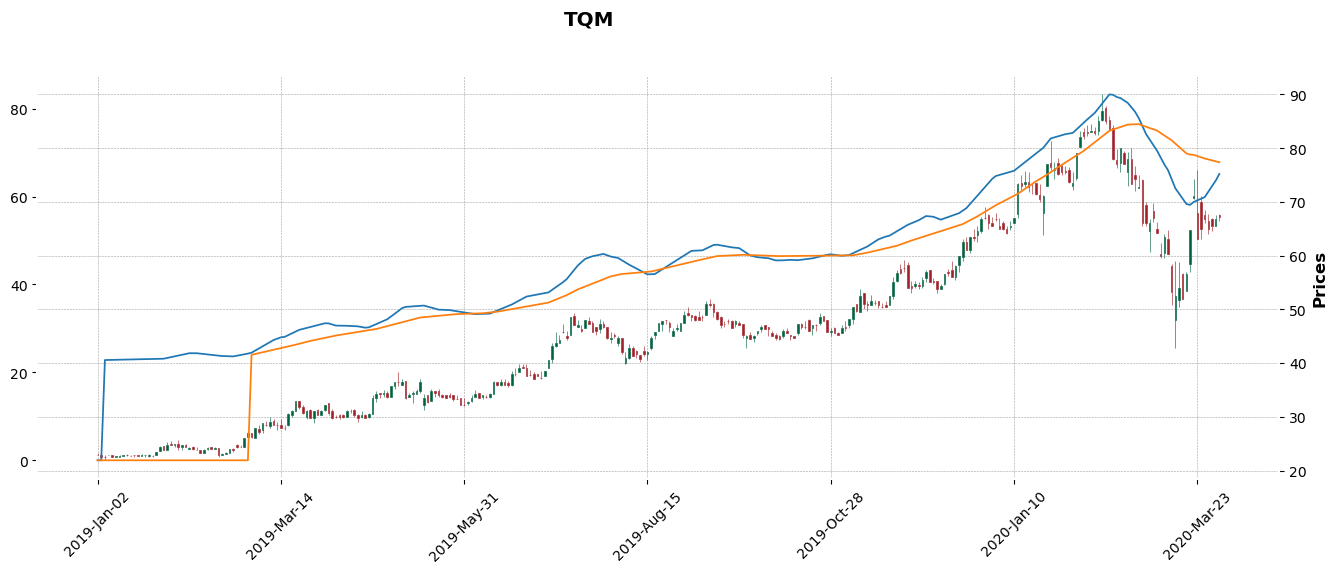

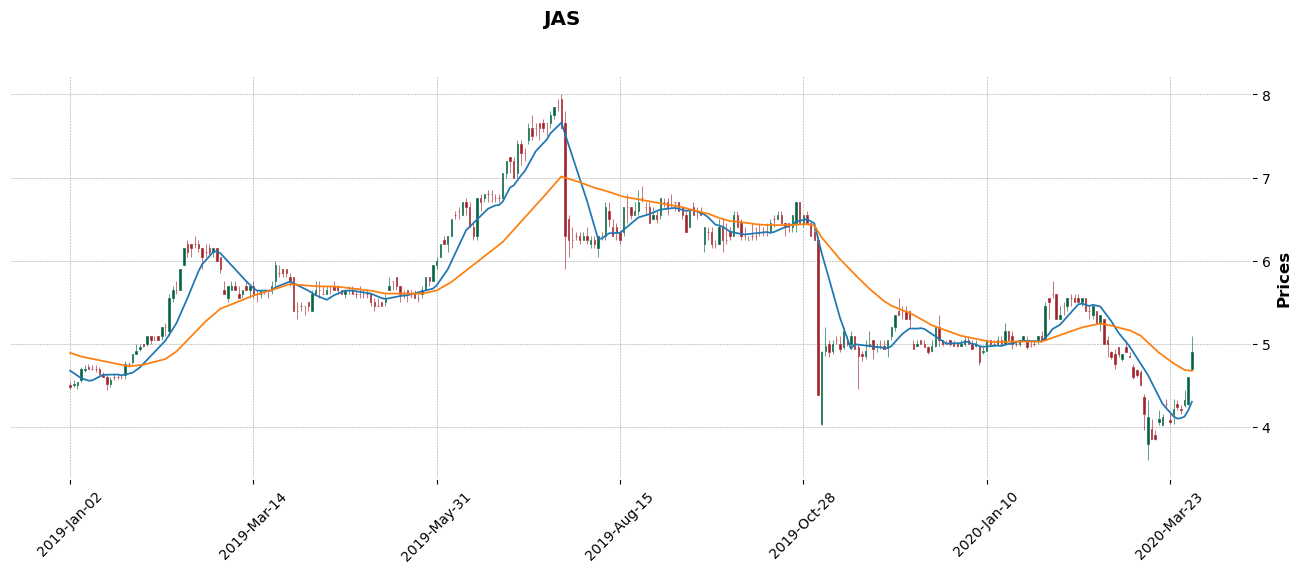

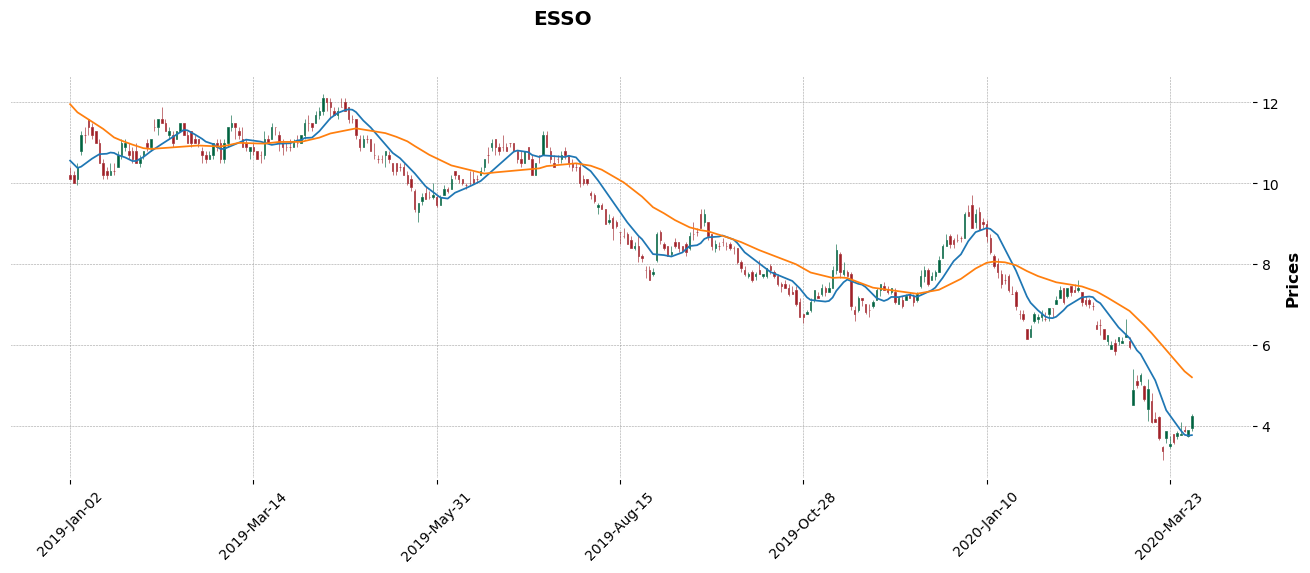

In [95]:
df_scan_ok = df_scan_result.loc[(df_scan_result.SCAN_RESULT == True)]

for symbol in df_scan_ok['SYMBOL']:
    scanned_symbol = symbol


    # ระบุ date_start กับ date_end หรือระบุ window_chart อย่างใดอย่างหนึ่ง
    date_start = '2018-01-01' # example: 20200101 format is YYYYmmdd or 2020-01-01 format is YYYY-mm-dd
    date_end = '2022-12-31' # example: 20200131 format is YYYYmmdd or 2020-01-31 format is YYYY-mm-dd
    window_chart = 2000 # candles

    chart_width = 30 # ระบุความกว้า่ง
    chart_height = 10 # ระบุความสูง

    # Get sub data
    df = data_range(symbols[scanned_symbol], from_date=date_start, to_date=date_end, window=window_chart)
    new_total_rows = df.shape[0]


    df_ohlc = pd.DataFrame()
    df_ohlc['DATETIME'] = df['DATETIME']
    df_ohlc['Open'] = df['OPEN']
    df_ohlc['High'] = df['HIGH']
    df_ohlc['Low'] = df['LOW']
    df_ohlc['Close'] = df['CLOSE']

    # Get sub data
    df_ohlc = data_range(df_ohlc, from_date=date_start, to_date=date_end, window=window_chart)

    df_ohlc['DATETIME'] = pd.to_datetime(df_ohlc['DATETIME'], format=datetime_format)
    df_ohlc.set_index('DATETIME', inplace=True)

    #===============================================================================================

    # Plot candles chart

    apdict_ma1 = mpf.make_addplot(df['MA1'])
    apdict_ma2 = mpf.make_addplot(df['MA2'])
    plot_ohlc(df_ohlc
                      , type='candle' # type='line'
                      , style='charles'
                      , title=scanned_symbol
                      , ylabel='Prices'
                      , figratio=(chart_width, chart_height)
                      , addplot=[apdict_ma1, apdict_ma2]
                      ,)